# 1. Data Background and Problem Formulation

In this project, a dataset is given with 900+ data each corresponding to individual indicators of users' experience surveys revolving around proposed system designs -- and how would potential users react or perceive this notion. 

The goal is to provide a deep learning model with an acceptable rate of AUC (0.7 to 0.9) on test dataset in order to be able to predict certain words clearly.

To gain a better sense of the data, we first import the necessities to run the overall code.

---


In [1]:
# Configure output settings to prettify print display

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
# Ignore warnings to prettify print

import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install scikit-multilearn
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import imblearn

You should consider upgrading via the 'c:\users\chari\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


##1.1. Importing the data
We can then import the data via `pandas` package to see the overall nature of the data, the outputs, and the datatypes.

In [5]:
df = pd.read_excel('Sample.xlsx', sheet_name='PROMISE-Extended_Ivan33')
df.drop(columns=['ID', 'ProjectID', 'Class'], axis=1, inplace=True)
df.sample(n=10, random_state=1)

Requirements  \
718  Secure data transfer over the Internet could b...   
637  The system shall validate the amount is availa...   
759  Sensitive data will be encrypted before being ...   
366  PME Subsystem shall allow building product men...   
543  The system shall be responsive. At the DePaul ...   
41   The product shall synchronize with the office ...   
120  Program Administrators and Nursing Staff Membe...   
725  It must be able to download the most recent me...   
795  Customer must logout of the site after purchas...   
672  Changes made to the Manage My ID website can b...   

     obstructive<==>supportive  complicated<==>easy  inefficient<==>efficient  \
718                          7                    5                         6   
637                          7                    6                         7   
759                          7                    6                         7   
366                          5                    4                         6   
543                          6                    6                         7   
41                           5                    5                         5   
120                          6                    5                         6   
725                          6                    7                         6   
795                          3                    2                         3   
672                          4                    3                         4   

      confusing<==>clear  boring<==>exciting  not interesting<==>interesting  \
718                    6                   3                               4   
637                    7                   2                               3   
759                    7                   4                               4   
366                    5                   3                               4   
543                    7                   5                               6   
41                     5                   5                               4   
120                    5                   5                               4   
725                    7                   3                               4   
795                    2                   1                               2   
672                    3                   3                               4   

     conventional<==>inventive  usual<==>leading edge  
718                          3                      3  
637                          1                      1  
759                          2                      3  
366                          4                      4  
543                          3                      4  
41                           4                      5  
120                          3                      2  
725                          3                      3  
795                          4                      6  
672                          4                      5

In [6]:
data=df.copy()
df.columns

Index(['Requirements', 'obstructive<==>supportive', 'complicated<==>easy',
       'inefficient<==>efficient', ' confusing<==>clear', 'boring<==>exciting',
       'not interesting<==>interesting', 'conventional<==>inventive',
       'usual<==>leading edge'],
      dtype='object')

In [7]:
data['mix']=data['obstructive<==>supportive']+data['complicated<==>easy']+data['inefficient<==>efficient']+data[' confusing<==>clear']+data['boring<==>exciting']+data['not interesting<==>interesting']+data['conventional<==>inventive']+data['usual<==>leading edge']

In [8]:
data.head()

Requirements  \
0  The system shall refresh the display every 60 ...   
1  The application shall match the color of the s...   
2  If projected  the data must be readable.  On a...   
3  The product shall be available during normal b...   
4  If projected  the data must be understandable....   

   obstructive<==>supportive  complicated<==>easy  inefficient<==>efficient  \
0                          3                    4                         3   
1                          7                    2                         5   
2                          7                    4                         7   
3                          7                    2                         7   
4                          7                    2                         7   

    confusing<==>clear  boring<==>exciting  not interesting<==>interesting  \
0                    3                   4                               3   
1                    5                   3                               3   
2                    7                   5                               5   
3                    5                   5                               5   
4                    7                   5                               7   

   conventional<==>inventive  usual<==>leading edge  mix  
0                          6                      6   32  
1                          6                      6   37  
2                          5                      4   44  
3                          5                      6   42  
4                          3                      3   41

## 1.2. Column Definitions
### 1.2.1. Features

Features are only represented in the first column, which is the `Requirements` column. This column represents the question and/or the funcionalities of the system itself.

### 1.2.2. Labels

Labels, on the other hand, comprised of 8 columns in total. They are:
* **obstructive<==>supportive**, measuring supportiveness.
* **complicated<==>easy**, measuring ease-of-use.
* **inefficient<==>efficient**, measuring efficiency.
* **confusing<==>clear**, measuring brevity and clarity.
* **boring<==>exciting**, measuring excitement.
* **not interesting<==>interesting**, measuring appeal.
* **conventional<==>inventive**, measuring innovation.
* **usual<==>leading edge**, measuring technology usage.

The scales on the labels vary from 1 to 7, in which values closer to 1 corresponds to a more negative connotation, while values closer to 7 is likely to be more positive.

For example, for column `boring<==>exciting`, if a user gives it a 3, whilst this may seem neutral at first glance, we can infer that the user does not regard this system design as easy-to-use -- otherwise they would give it a score of 5 or 6.

For this task, we'll run multiclass multilabel regression since we obtained a good AUC with multiclass regression on one column before with simple regression. **The trick here is to not use a single column.**

With this, we might want to approach the problem within the scope of [Multi-output Regression](https://machinelearningmastery.com/deep-learning-models-for-multi-output-regression/)

First, we separate the labels from the data.

In [9]:
features = df.iloc[:, 0].values # First column in the entire set
labels = df.iloc[:, np.r_[1:9]].values
print("Features is now of type:", type(features), "with shape", features.shape)
print("Labels is now of type:", type(labels), "with shape", labels.shape)

Features is now of type: <class 'numpy.ndarray'> with shape (969,)
Labels is now of type: <class 'numpy.ndarray'> with shape (969, 8)


We know from previous work that the dataset is very much imbalanced, so we would want to try oversampling across all columns and make them our new label. But first, we would want to convert features as word vectors first.

## 1.3. Quick EDA

We can visualize the most used words via `wordcloud` used in our dataset.

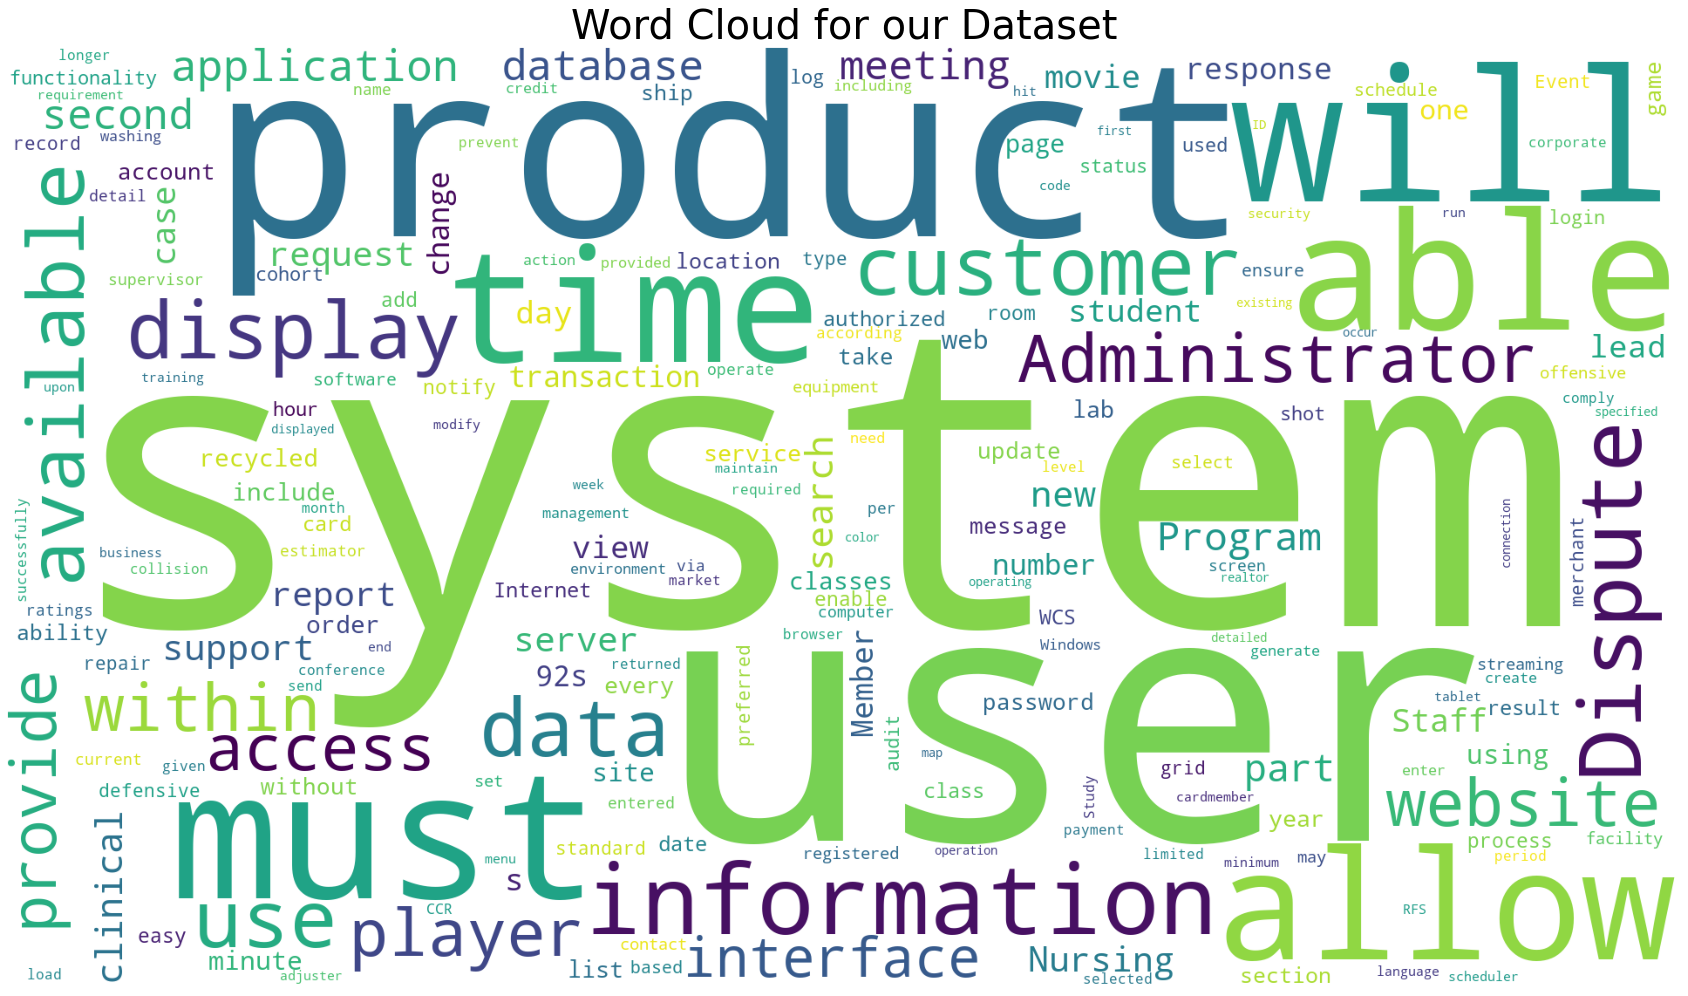

In [10]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(30,20))
text =df['Requirements'].values
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1920,
                          height=1080
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Word Cloud for our Dataset",fontsize=40)
plt.imshow(cloud)

In [11]:
from collections import Counter
for i in range(8):
  print("Column:", df.columns[1:][i])
  print(Counter(labels[:,i]))

Column: obstructive<==>supportive
Counter({7: 418, 6: 281, 5: 152, 4: 63, 3: 37, 2: 16, 1: 2})
Column: complicated<==>easy
Counter({6: 278, 5: 254, 7: 210, 4: 144, 3: 57, 2: 24, 1: 2})
Column: inefficient<==>efficient
Counter({7: 406, 6: 306, 5: 128, 4: 71, 3: 36, 2: 18, 1: 4})
Column:  confusing<==>clear
Counter({7: 443, 6: 245, 5: 148, 4: 68, 3: 38, 2: 23, 1: 4})
Column: boring<==>exciting
Counter({3: 256, 4: 249, 5: 185, 2: 142, 6: 89, 7: 26, 1: 22})
Column: not interesting<==>interesting
Counter({4: 265, 3: 245, 5: 222, 2: 103, 6: 92, 7: 23, 1: 19})
Column: conventional<==>inventive
Counter({3: 273, 2: 267, 4: 164, 5: 102, 1: 101, 6: 55, 7: 7})
Column: usual<==>leading edge
Counter({3: 259, 2: 253, 4: 177, 5: 112, 1: 101, 6: 61, 7: 6})


# 2. Pre-processing
---

## 2.1. Tokenization

Tokenization means splitting each word and vectorizing a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary). This process cleans up our text, lowercase, and remove punctuations. This step is basically the same from our previous work involving LSTMs.

This way, we can see which words appear the most in our training set.

In [12]:
tokenizer = Tokenizer(num_words = 2000, oov_token="<OOV>")
tokenizer.fit_on_texts(features)
word_index = tokenizer.word_index
dict(list(word_index.items())[:10])

{'<OOV>': 1,
 'the': 2,
 'shall': 3,
 'to': 4,
 'system': 5,
 'of': 6,
 'be': 7,
 'a': 8,
 'and': 9,
 'product': 10}

After tokenization, the next step is to turn those tokens into lists of sequence.

In [13]:
sequences = tokenizer.texts_to_sequences(features)
print(sequences[0]) # This corresponds to the first sentence in the training data.

[2, 5, 3, 674, 2, 32, 96, 675, 49]


## 2.2. Padding

When we train neural networks for NLP, we need sequences to be in the same size, that's why we use padding. Padding means that we convert all instances of the training data towards the same size. To do this, we need to specify a fixed length to transform all the instances on.

For the project, we can set the sequence by looking quickly at the average proportion of the training words.

In [14]:
import math
word_counts = []
for i in (features):
  word_counts.append(len(i.split(" ")))
print("Average word counts:" , sum(word_counts)/len(word_counts))

# Round max length of padding to the nearest tenth
max_length = math.ceil((sum(word_counts)/len(word_counts))/10) * 10
print("Padded onto length: ", max_length)

# Delete unused variable
del word_counts 

Average word counts: 18.223942208462333
Padded onto length:  20


We can then proceed to do the actual padding. This is done for all instances of the training example.

In [15]:
padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

for i in range(5):
  print("Sequence of length", len(sequences[i]), "was padded onto", len(padded[i]))

Sequence of length 9 was padded onto 20
Sequence of length 16 was padded onto 20
Sequence of length 29 was padded onto 20
Sequence of length 36 was padded onto 20
Sequence of length 35 was padded onto 20


In [16]:
padded

array([[  2,   5,   3, ...,   0,   0,   0],
       [  2,  45,   3, ...,   0,   0,   0],
       [ 69, 879,   2, ...,  17,   4, 451],
       ...,
       [  2,   1,  36, ...,  91, 309,  12],
       [  2,   5,   3, ...,   9, 102,   4],
       [  2,  36,  15, ..., 304,  15,   7]])

## 2.3. SMOTE Oversampling

Generally, oversampling makes fake data so that the minority labels are not squashed by the majority.

Constraint of using SMOTE within this dataset is that it's very fragile to classes with only one example. Since SMOTE works via k-nearest neighbors, at least two members of a class would be mandatory for it to work.

Synthetic samples generated with respect to the most amount of classes in all columns so that input shape (features and labels) are consistent against each other.

## REVISION: ROS Oversampling

ROS generates random data as opposed to the better, more superior SMOTE which generates "more credible" data. We can't use SMOTE on all sheets because of the `n_neighbors` and distance constraint.

We find the least common multiple of all class members amount, and oversample from there to get the matrix dimensions uniform.

In [17]:
import copy
from collections import defaultdict, Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler
max_amount = np.lcm.reduce([1,2,3,4,5,6,7]) * 40
labels_processed = np.zeros((max_amount, 8))

for i in range(8):
  unique_classes = np.unique(df[df.columns[1:][i]])
  amount = [int(
      (max_amount/len(unique_classes)))
      ] * len(unique_classes)
  x = {k:v for (k,v) in zip(unique_classes, amount)}
  smt = RandomOverSampler(sampling_strategy=x)
  X, y = smt.fit_resample(padded, labels[:,i])
  labels_processed[:,i] = y
  print("Column", i, "done.")
  # We don't save nor use the X variable between each iteration, 
  # instead only using the last one.


print("Shape of input features is:", X.shape)
print("Shape of labels is:",labels_processed.shape)

Column 0 done.
Column 1 done.
Column 2 done.
Column 3 done.
Column 4 done.
Column 5 done.
Column 6 done.
Column 7 done.
Shape of input features is: (16800, 20)
Shape of labels is: (16800, 8)


In [18]:
# Sanity check time!
for i in range(8):
  print("For column", df.columns[1:][i])
  print(Counter(labels_processed[:,i]),"\n------")


print("First ten entries of the processed labels:\n", labels_processed[:10,:])
print("First ten entries of the processed features:\n", X[:10,:])

# Last and final assertion to catch matrix errors
try:
  assert(X.shape[0] == labels_processed.shape[0])
  print("Assertion completed!")
except AssertionError:
  print("Error!\nShape of X is", X.shape, "while labels is", labels_processed.shape)
  raise AssertionError

For column obstructive<==>supportive
Counter({3.0: 2400, 7.0: 2400, 5.0: 2400, 6.0: 2400, 2.0: 2400, 4.0: 2400, 1.0: 2400}) 
------
For column complicated<==>easy
Counter({4.0: 2400, 2.0: 2400, 3.0: 2400, 6.0: 2400, 1.0: 2400, 5.0: 2400, 7.0: 2400}) 
------
For column inefficient<==>efficient
Counter({3.0: 2400, 5.0: 2400, 7.0: 2400, 6.0: 2400, 2.0: 2400, 4.0: 2400, 1.0: 2400}) 
------
For column  confusing<==>clear
Counter({3.0: 2400, 5.0: 2400, 7.0: 2400, 6.0: 2400, 1.0: 2400, 4.0: 2400, 2.0: 2400}) 
------
For column boring<==>exciting
Counter({4.0: 2400, 3.0: 2400, 5.0: 2400, 2.0: 2400, 6.0: 2400, 7.0: 2400, 1.0: 2400}) 
------
For column not interesting<==>interesting
Counter({3.0: 2400, 5.0: 2400, 7.0: 2400, 4.0: 2400, 6.0: 2400, 2.0: 2400, 1.0: 2400}) 
------
For column conventional<==>inventive
Counter({6.0: 2400, 5.0: 2400, 3.0: 2400, 2.0: 2400, 4.0: 2400, 1.0: 2400, 7.0: 2400}) 
------
For column usual<==>leading edge
Counter({6.0: 2400, 4.0: 2400, 3.0: 2400, 2.0: 2400, 5.0: 

## 2.4. Train-test Splitting

Finally we get to this part. We can use sklearn's `train_test_split` to do the usual splitting for test set (validation set is specified within building the model in the next section).

Also, specifying `random_state` ensures reproducibility.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels_processed, test_size=0.2, random_state=42)

# Sanity check again and again
print("Training examples:", X_train.shape)
print("Training labels:", y_train.shape)
print("Test examples:", X_test.shape)
print("Test labels:", y_test.shape)

Training examples: (13440, 20)
Training labels: (13440, 8)
Test examples: (3360, 20)
Test labels: (3360, 8)


In [20]:
data = {'metric':['Accuracy', 'Precision', 'Recall', 'F1 Score','RMSE','AUC score']}
metric_df=pd.DataFrame(data)

In [21]:
metric_df.set_index(['metric'])


Empty DataFrame
Columns: []
Index: [Accuracy, Precision, Recall, F1 Score, RMSE, AUC score]

# 3. Modelling

## 3.1. Building the Model

Since we're training on augmented data, we're going to approach this as conventional regression compared to the LSTM approach we're doing it before.

LSTM model in this manner would result in a pretty bad metric score (around 0.5 to 0.7 F1-score) whereas our fully-connected dense layers resulted in a pretty satisfying F1, which is around 0.8 to 1 for each column.

In [22]:
# Wrapper functions for result interpretation
from matplotlib import pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

def transform_results(estimates):
  res = []
  for x in estimates:
    if x > 7:
      x = 7
      res.append(x)
    else:
      res.append(x)
  return res

In [23]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

initializer = tf.keras.initializers.RandomNormal(seed=1) # Reproducibility

model = Sequential(name="classifier_NN")
model.add(tf.keras.Input(shape=(X_train.shape[1],))) # Automatically detect features as input nodes
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(8)) # output layer
opt = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'], optimizer = opt)
model.summary()

Model: "classifier_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5376      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)             

Epoch 1/150
588/588 - 1s - loss: 4.2288 - mae: 1.5944 - val_loss: 2.1873 - val_mae: 1.1681
Epoch 2/150
588/588 - 1s - loss: 2.0432 - mae: 1.1350 - val_loss: 1.5419 - val_mae: 0.9811
Epoch 3/150
588/588 - 1s - loss: 1.5181 - mae: 0.9546 - val_loss: 1.1791 - val_mae: 0.8342
Epoch 4/150
588/588 - 1s - loss: 1.3498 - mae: 0.8819 - val_loss: 1.1305 - val_mae: 0.8338
Epoch 5/150
588/588 - 1s - loss: 1.2329 - mae: 0.8269 - val_loss: 1.0679 - val_mae: 0.8106
Epoch 6/150
588/588 - 1s - loss: 1.1048 - mae: 0.7704 - val_loss: 0.8997 - val_mae: 0.6824
Epoch 7/150
588/588 - 1s - loss: 1.0330 - mae: 0.7264 - val_loss: 0.8045 - val_mae: 0.6179
Epoch 8/150
588/588 - 1s - loss: 0.9843 - mae: 0.6973 - val_loss: 0.8736 - val_mae: 0.6768
Epoch 9/150
588/588 - 1s - loss: 0.9166 - mae: 0.6659 - val_loss: 0.7738 - val_mae: 0.5833
Epoch 10/150
588/588 - 1s - loss: 0.8859 - mae: 0.6449 - val_loss: 0.7607 - val_mae: 0.5987
Epoch 11/150
588/588 - 1s - loss: 0.8632 - mae: 0.6349 - val_loss: 0.6851 - val_mae: 0.52

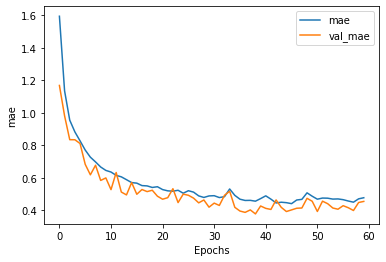

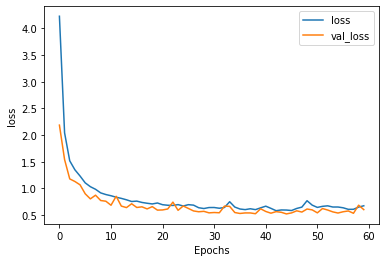

In [24]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(X_train, y_train, epochs=150, batch_size = 16, validation_split=0.3, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=2)

plot_graphs(history, "mae")
plot_graphs(history, "loss")

## 3.2. Result Interpretation and Evaluation

Here we evaluate on `y_test`, which we made sure earlier comes from a similar distribution within the training set itself. 

Resulted on a pretty confident `mae` and `mse`, which I would say a good result considering the number of classes we have.

In [25]:
scores = model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 2s 686us/step - loss: 0.6218 - mae: 0.4491
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 62.18%
mae: 44.91%


We can also print classification report from each column.

In [26]:
from sklearn.metrics import classification_report, f1_score
y_pred = model.predict(X_test)
for i in range(8):
  print("Column", df.columns[1:][i])
  estimates = [round(float(x)) for x in y_pred[:,i]]
  estimates = transform_results(estimates)
  print(np.unique(estimates))
  print(classification_report(y_test[:,i], estimates), "\n------")

Column obstructive<==>supportive
[1 2 3 4 5 6 7]
              precision    recall  f1-score   support

         1.0       0.93      0.94      0.93       462
         2.0       0.77      0.49      0.60       482
         3.0       0.54      0.68      0.60       510
         4.0       0.62      0.66      0.64       517
         5.0       0.46      0.66      0.54       467
         6.0       0.69      0.51      0.59       470
         7.0       0.81      0.68      0.74       452

    accuracy                           0.66      3360
   macro avg       0.69      0.66      0.66      3360
weighted avg       0.68      0.66      0.66      3360
 
------
Column complicated<==>easy
[1 2 3 4 5 6 7]
              precision    recall  f1-score   support

         1.0       0.93      0.93      0.93       463
         2.0       0.80      0.65      0.72       485
         3.0       0.61      0.69      0.65       501
         4.0       0.64      0.67      0.66       515
         5.0       0.58      0.7

## 3.3. Prepare the Plotting Set

Due to the multi-dimensional nature of our results and test set, we need to reshape the predictions by using `numpy`'s `flatten()` attribute, which flattens the array column-wise if we specify the argument `order='F'` to flatten in Fortran-style order.

Keep in mind this will indeed aggregate the metrics like on the `classification_report()` below.

In [27]:
y_pred_flattened = y_pred.flatten(order='F')
y_test_flattened = y_test.flatten(order='F')
y_classified = [round(float(x)) for x in y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test_flattened[:10])
print("Predicted labels:",y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test_flattened, y_classified))

First ten examples of the test set:
Truth labels: [2. 1. 2. 1. 4. 3. 4. 3. 3. 7.]
Predicted labels: [3, 1, 2, 1, 5, 4, 4, 3, 4, 1]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       0.94      0.94      0.94      3691
         2.0       0.82      0.65      0.73      3921
         3.0       0.64      0.73      0.68      3952
         4.0       0.72      0.75      0.73      4161
         5.0       0.65      0.78      0.71      3786
         6.0       0.76      0.73      0.75      3748
         7.0       0.91      0.76      0.83      3621

    accuracy                           0.76     26880
   macro avg       0.78      0.76      0.77     26880
weighted avg       0.77      0.76      0.76     26880



In [28]:
# Wrapper function(s) from earlier notebook
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
  """
  Modified function behavior, now predicts column-wise
  """
  y_score = clf.predict_proba(X_test)
  target_names = np.unique(y_test)
  # structures
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  # calculate dummies once
  y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
  print(y_test_dummies.shape, y_score.shape)
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  
# roc for each class
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver operating characteristic')
    
  for i in range(len(target_names)):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], target_names[i]))
  
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()

  return roc_auc

def plot_multiclass_roc_LSTM(X_test, y_test, n_classes, figsize=(17, 6), model=model):
  """
  Custom-made function to plot ROC curve.
  Sorry I can't run because I don't have the excel file used for this particular notebook.
  """
  y_score = to_categorical(y_test)
  target_names = ["obstructive vs supportive",
                  "complicated vs easy",
                  "inefficient vs efficient",
                  " confusing vs clear",
                  "boring vs exciting",
                  "not interesting vs interesting",
                  "conventional vs inventive",
                  "usual vs leading edge"]
  # structures
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
 
  # One-liner transformation of our existing result 
  y_test_dummies = np.pad(pd.get_dummies(y_classified, drop_first=False).values, 
                          ((0,0), 
                           (min(labels.flatten()),0)))
  print(y_test_dummies.shape, y_score.shape) # Quick debug purposes after one-hot encoding
                                             # to ensure matrix dimension is right
  for i in range(1, n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  
# roc for each class
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Column-wise Receiver Operating Characteristic Plot')
    
  for i in range(1, len(target_names)):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], target_names[i]))
  
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()


# plot_multiclass_roc_LSTM(X_test, y_classified, 8, figsize=(17, 6))

ROC AUC score: 0.8615240761953316


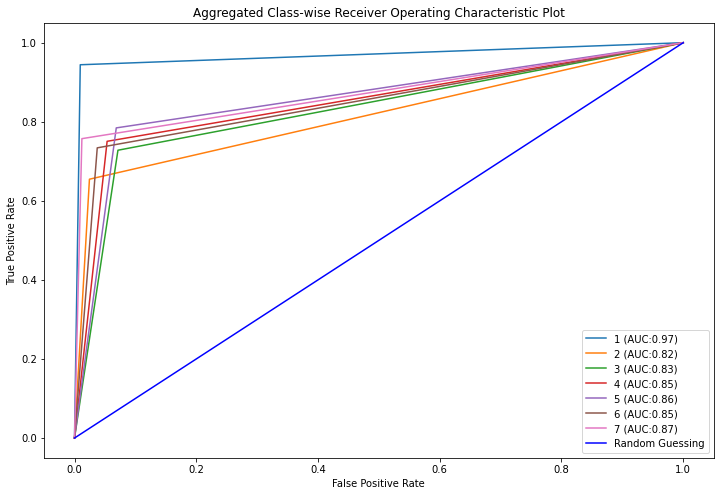

In [29]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


def score_auc(y_test, y_pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(set(labels.flatten())):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test_flattened, y_classified))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title('Aggregated Class-wise Receiver Operating Characteristic Plot')
plt.savefig("auc.png")
plt.show()

## 3.4. Exporting the Model

We can export the model to `HDF5` format designed to store large amounts of information. More info:
* [Wikipedia](https://en.wikipedia.org/wiki/Hierarchical_Data_Format)
* [TensorFlow Documentation](https://www.tensorflow.org/tutorials/keras/save_and_load#hdf5_format)

In [28]:
model.save('UX_Regression.h5')

## 3.5. XGB Method
For comparison, we try implementing XGB.

For column: obstructive<==>supportive
[16:16:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.84      0.89      0.87       482
         3.0       0.77      0.73      0.75       510
         4.0       0.69      0.68      0.68       517
         5.0       0.64      0.67      0.66       467
         6.0       0.73      0.71      0.72       470
         7.0       0.81      0.81      0.81       452

    accuracy                           0.78      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.78      0.78      0.78      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [ 

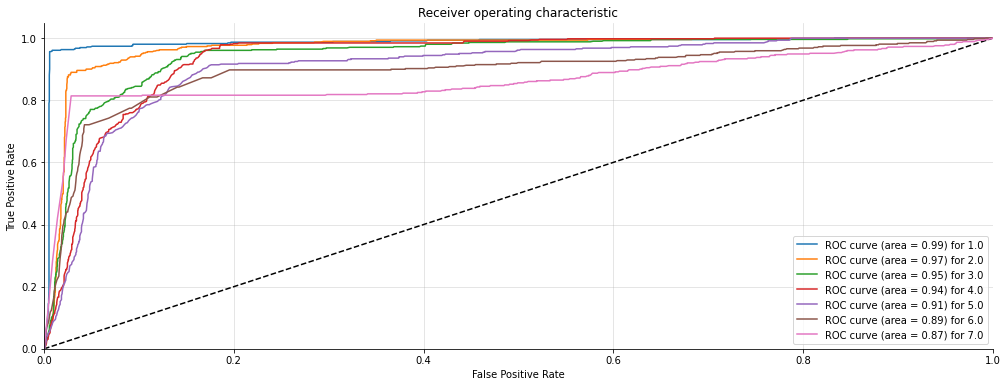

For column: complicated<==>easy
[16:16:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.84      0.89      0.87       485
         3.0       0.77      0.74      0.75       501
         4.0       0.71      0.70      0.71       515
         5.0       0.71      0.76      0.73       460
         6.0       0.83      0.79      0.81       484
         7.0       0.89      0.90      0.90       452

    accuracy                           0.82      3360
   macro avg       0.82      0.82      0.82      3360
weighted avg       0.82      0.82      0.82      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  0 430

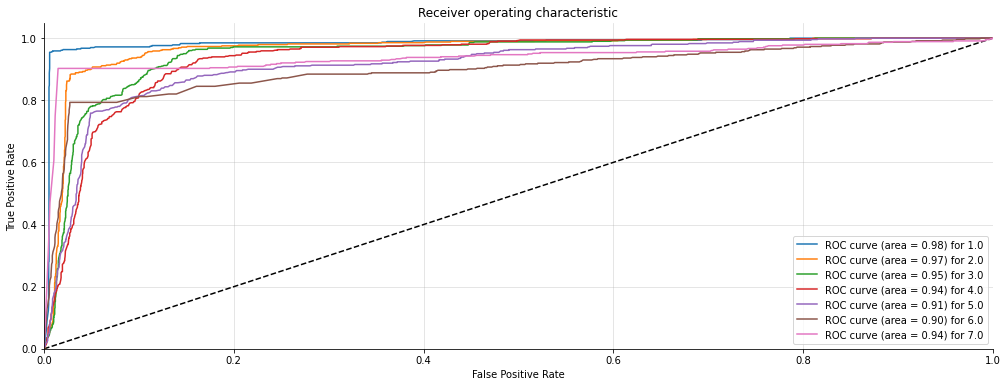

For column: inefficient<==>efficient
[16:16:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.85      0.89      0.87       482
         3.0       0.76      0.74      0.75       506
         4.0       0.69      0.67      0.68       526
         5.0       0.65      0.68      0.66       458
         6.0       0.72      0.69      0.71       475
         7.0       0.82      0.83      0.82       451

    accuracy                           0.78      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.78      0.78      0.78      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  

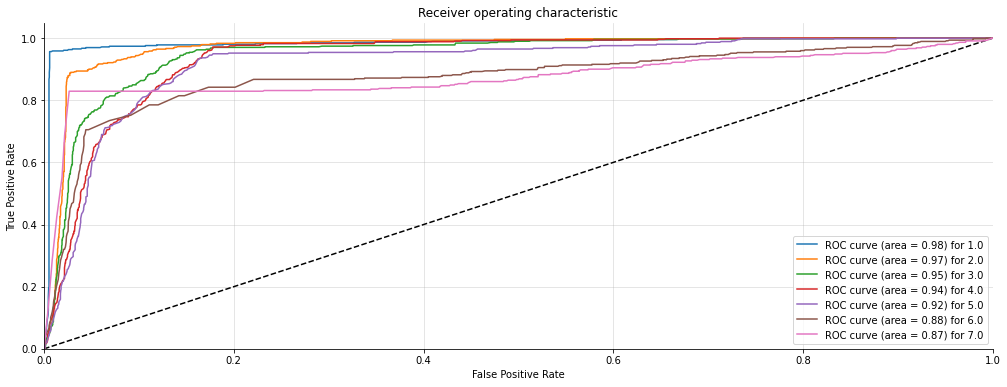

For column:  confusing<==>clear
[16:16:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.85      0.88      0.86       488
         3.0       0.76      0.73      0.74       506
         4.0       0.68      0.67      0.67       516
         5.0       0.65      0.69      0.67       456
         6.0       0.73      0.71      0.72       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.77      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  0 429

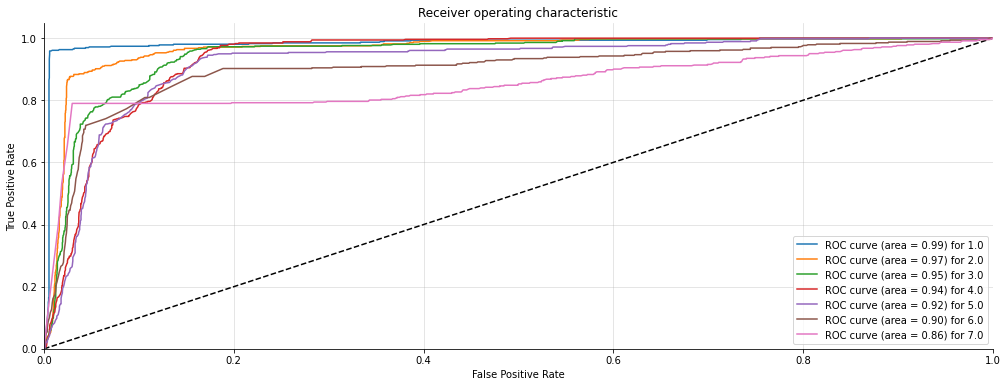

For column: boring<==>exciting
[16:17:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.87      0.88      0.88       491
         3.0       0.83      0.81      0.82       487
         4.0       0.86      0.87      0.87       518
         5.0       0.91      0.92      0.92       487
         6.0       0.95      0.96      0.95       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  5 434 

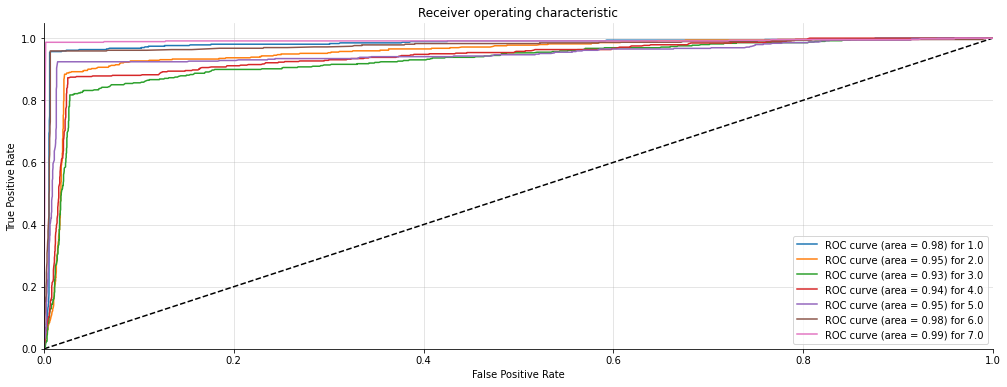

For column: not interesting<==>interesting
[16:17:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.86      0.87      0.86       495
         3.0       0.82      0.79      0.81       490
         4.0       0.83      0.84      0.83       519
         5.0       0.89      0.91      0.90       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0

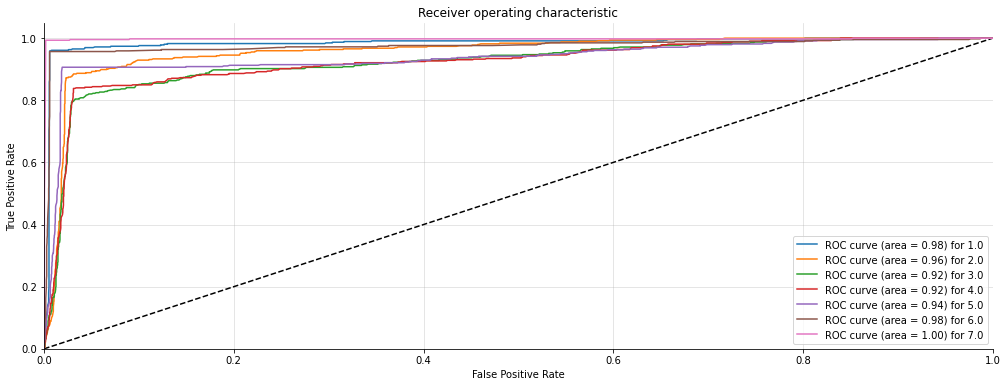

For column: conventional<==>inventive
[16:17:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.96      0.95      0.96       502
         3.0       0.94      0.94      0.94       474
         4.0       0.95      0.95      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [ 

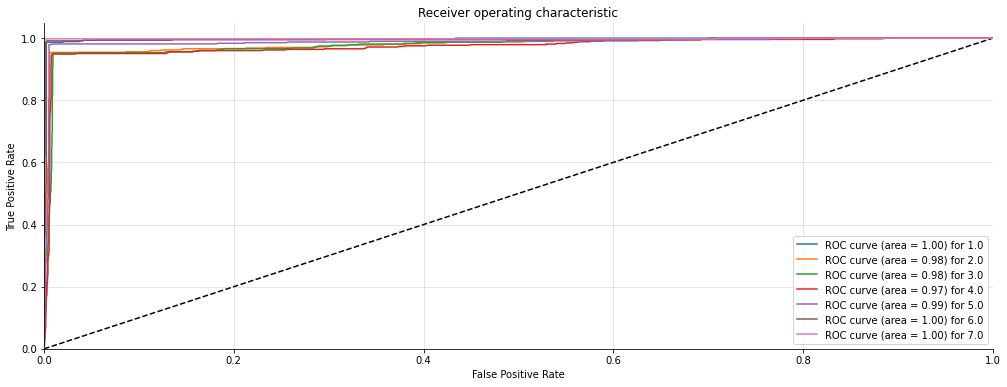

For column: usual<==>leading edge
[16:17:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 4

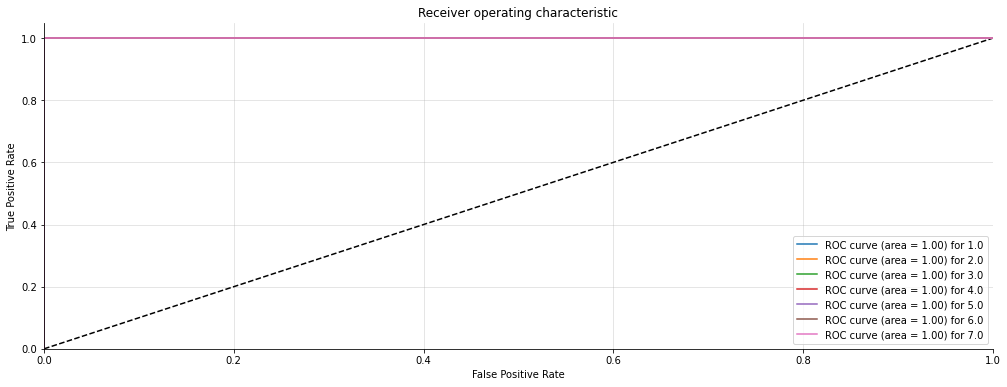

In [30]:
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error

acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def XGBmodel(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    xgb_classifier = XGBClassifier()
    xgb_classifier.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in xgb_classifier.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(xgb_classifier, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  XGBmodel(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))


In [31]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE -score :{}".format(np.mean(rms)))
print("average AUC -score :{}".format(np.mean(aucscore)))
metric_df['XGB'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.865625
average Precision :0.8656731709259076
average Recall :0.865625
average F1 -score :0.8655140505570209
average RMSE -score :0.6028004411448414
average AUC -score :0.9214404308138415


## 3.6. SVM Method

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.47      0.88      0.61       462
         2.0       0.61      0.55      0.58       482
         3.0       0.67      0.46      0.55       510
         4.0       0.63      0.42      0.50       517
         5.0       0.52      0.45      0.48       467
         6.0       0.59      0.60      0.60       470
         7.0       0.78      0.81      0.80       452

    accuracy                           0.59      3360
   macro avg       0.61      0.60      0.59      3360
weighted avg       0.61      0.59      0.59      3360

Confusion Matrix: 
 [[408  34   0   0   5   8   7]
 [139 265  46   3   9  14   6]
 [102  40 236  79  31  22   0]
 [ 83  37  33 216 119  26   3]
 [ 83  22  13  20 210 119   0]
 [ 37  26   8  14  16 284  85]
 [ 23  14  15  10  12  10 368]]
Accuracy Score : 0.5913690476190476
Precision Score : 0.6105504808371885
Recall Score : 0.5913690476190476
F1 Score : 0.5851994

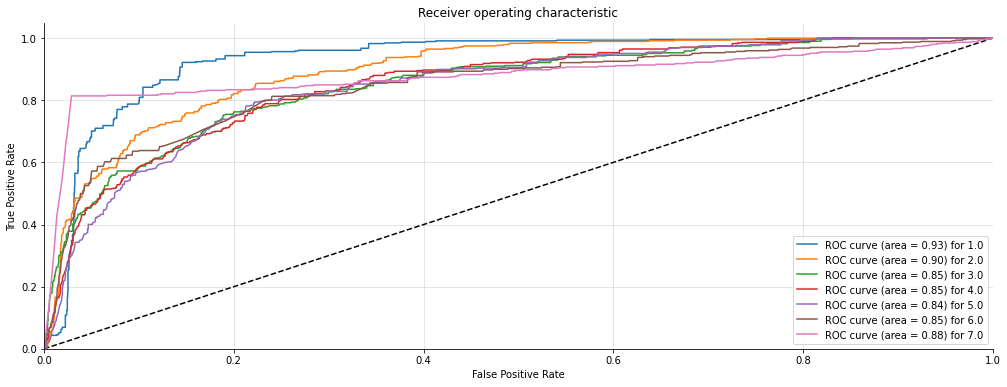

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.47      0.88      0.61       463
         2.0       0.62      0.55      0.58       485
         3.0       0.66      0.46      0.54       501
         4.0       0.66      0.46      0.55       515
         5.0       0.59      0.49      0.54       460
         6.0       0.66      0.68      0.67       484
         7.0       0.88      0.90      0.89       452

    accuracy                           0.63      3360
   macro avg       0.65      0.63      0.63      3360
weighted avg       0.65      0.63      0.62      3360

Confusion Matrix: 
 [[408  31   3   0   5   9   7]
 [139 266  45   2  10  19   4]
 [ 99  42 230  85  27  18   0]
 [ 84  28  35 239 100  28   1]
 [ 83  24  21  13 227  92   0]
 [ 44  26  10  19  10 331  44]
 [ 18  10   4   3   5   4 408]]
Accuracy Score : 0.6276785714285714
Precision Score : 0.6485838166220406
Recall Score : 0.6276785714285714
F1 Score : 0.6229560161993

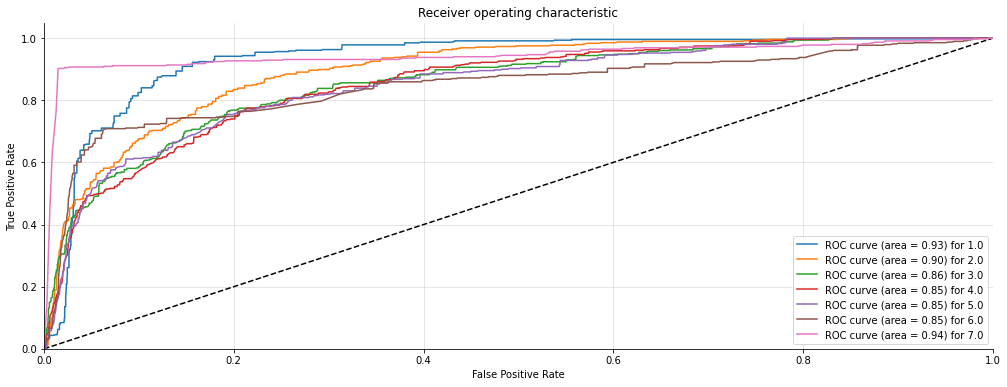

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.46      0.88      0.60       462
         2.0       0.62      0.55      0.58       482
         3.0       0.65      0.45      0.53       506
         4.0       0.64      0.42      0.50       526
         5.0       0.50      0.45      0.47       458
         6.0       0.62      0.61      0.61       475
         7.0       0.79      0.83      0.81       451

    accuracy                           0.59      3360
   macro avg       0.61      0.60      0.59      3360
weighted avg       0.61      0.59      0.59      3360

Confusion Matrix: 
 [[408  30   3   0   5   9   7]
 [142 264  46   3  13  11   3]
 [ 98  39 228  84  35  19   3]
 [ 86  35  37 220 121  20   7]
 [ 91  19  11  20 205 112   0]
 [ 46  19  15   9  18 289  79]
 [ 22  17  10  10  12   6 374]]
Accuracy Score : 0.5916666666666667
Precision Score : 0.6121203168388367
Recall Score : 0.5916666666666667
F1 Score : 0.58566768

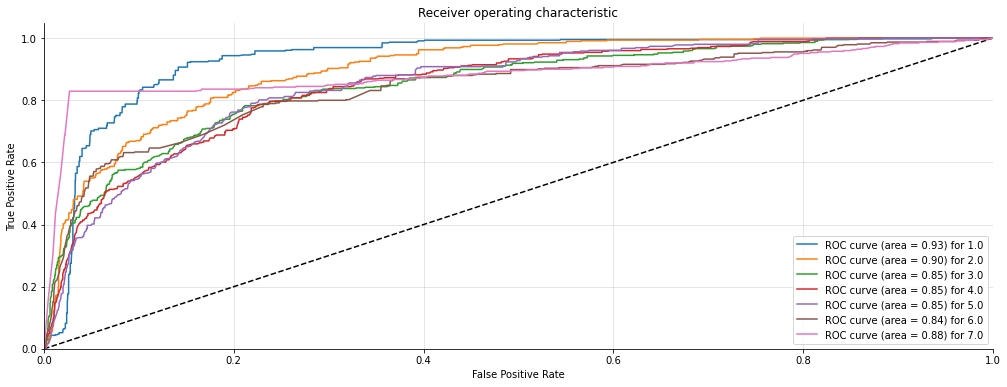

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.46      0.89      0.61       461
         2.0       0.62      0.54      0.58       488
         3.0       0.66      0.44      0.53       506
         4.0       0.62      0.42      0.50       516
         5.0       0.52      0.46      0.49       456
         6.0       0.60      0.61      0.60       471
         7.0       0.77      0.79      0.78       462

    accuracy                           0.59      3360
   macro avg       0.61      0.59      0.59      3360
weighted avg       0.61      0.59      0.58      3360

Confusion Matrix: 
 [[408  33   0   0   5   8   7]
 [147 265  44   4  10  12   6]
 [ 98  41 225  86  30  23   3]
 [ 82  26  32 219 124  26   7]
 [ 79  16  15  19 211 116   0]
 [ 36  24  13  10  16 286  86]
 [ 31  20  10  14  11   9 367]]
Accuracy Score : 0.5895833333333333
Precision Score : 0.6094932260907648
Recall Score : 0.5895833333333333
F1 Score : 0.5837015644008

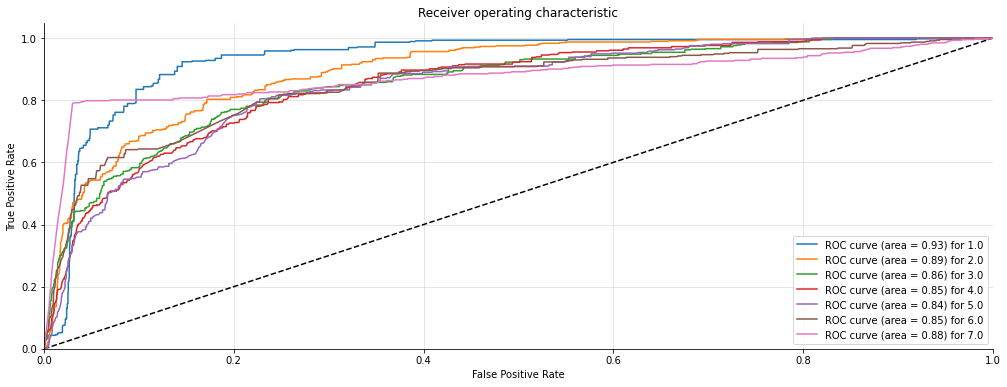

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.48      0.87      0.62       463
         2.0       0.62      0.55      0.58       491
         3.0       0.70      0.51      0.59       487
         4.0       0.80      0.57      0.66       518
         5.0       0.77      0.59      0.67       487
         6.0       0.77      0.87      0.82       462
         7.0       0.97      0.99      0.98       452

    accuracy                           0.70      3360
   macro avg       0.73      0.71      0.70      3360
weighted avg       0.73      0.70      0.70      3360

Confusion Matrix: 
 [[405  30   8   0   0  13   7]
 [140 270  38   8  17  18   0]
 [ 96  61 248  47  19  16   0]
 [ 67  43  32 293  48  31   4]
 [ 98  20  25  15 289  40   0]
 [ 38   9   4   2   3 401   5]
 [  0   0   1   1   1   3 446]]
Accuracy Score : 0.7
Precision Score : 0.7282321170229997
Recall Score : 0.7
F1 Score : 0.6985920724844651
(3360, 7) (3360, 7)


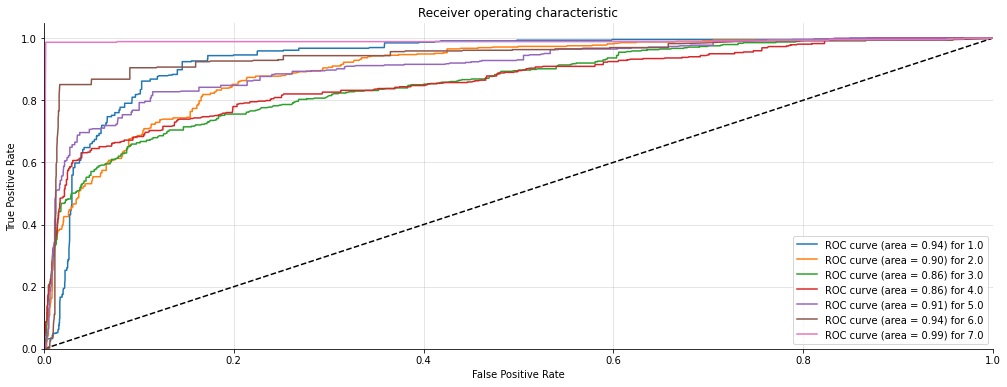

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.48      0.90      0.62       461
         2.0       0.64      0.54      0.59       495
         3.0       0.68      0.50      0.57       490
         4.0       0.77      0.54      0.63       519
         5.0       0.74      0.57      0.64       481
         6.0       0.77      0.86      0.82       465
         7.0       0.97      0.99      0.98       449

    accuracy                           0.69      3360
   macro avg       0.72      0.70      0.69      3360
weighted avg       0.72      0.69      0.69      3360

Confusion Matrix: 
 [[416  18   8   0   0  12   7]
 [147 267  42   7  14  18   0]
 [102  55 243  48  25  17   0]
 [ 69  46  38 279  53  30   4]
 [ 99  20  24  25 274  39   0]
 [ 38   8   4   2   6 402   5]
 [  0   0   1   1   0   1 446]]
Accuracy Score : 0.6925595238095238
Precision Score : 0.7196665388198612
Recall Score : 0.6925595238095238
F1 Score : 0.68

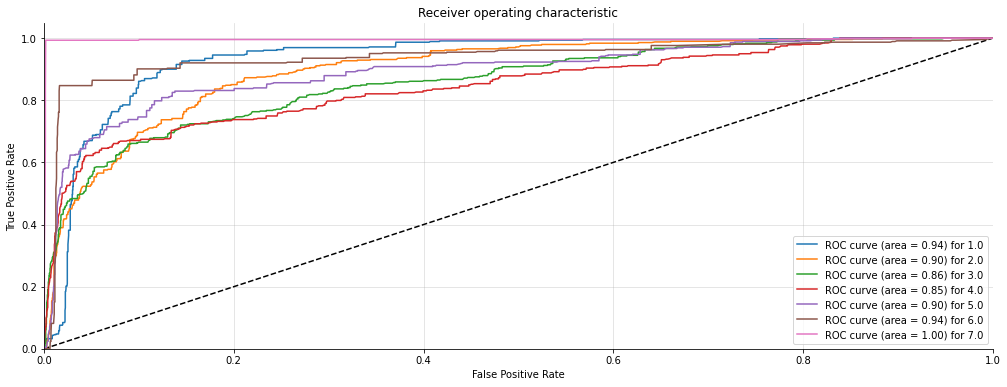

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.49      0.92      0.64       460
         2.0       0.71      0.60      0.65       502
         3.0       0.85      0.61      0.71       474
         4.0       0.85      0.65      0.74       527
         5.0       0.83      0.67      0.74       486
         6.0       0.81      0.88      0.84       459
         7.0       0.98      1.00      0.99       452

    accuracy                           0.75      3360
   macro avg       0.79      0.76      0.76      3360
weighted avg       0.79      0.75      0.76      3360

Confusion Matrix: 
 [[421  17   3   0   0  12   7]
 [139 301  24  14  12  11   1]
 [ 74  53 289  22  19  17   0]
 [ 76  31  19 341  33  26   1]
 [ 95  13   5  22 324  27   0]
 [ 48   6   0   0   2 403   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.7529761904761905
Precision Score : 0.7911717517881709
Recall Score : 0.7529761904761905
F1 Score : 0.7561447

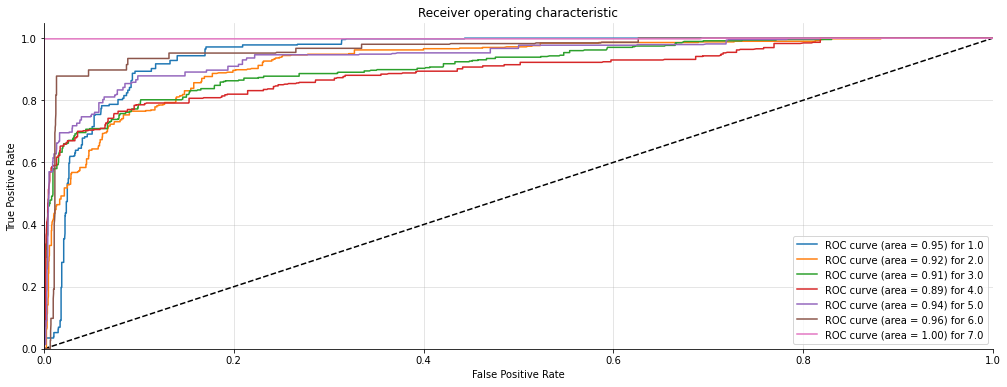

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.50      0.91      0.65       459
         2.0       0.76      0.67      0.71       496
         3.0       0.89      0.66      0.76       478
         4.0       0.90      0.68      0.78       523
         5.0       0.86      0.68      0.76       491
         6.0       0.83      0.89      0.86       462
         7.0       0.98      1.00      0.99       451

    accuracy                           0.78      3360
   macro avg       0.82      0.78      0.79      3360
weighted avg       0.82      0.78      0.78      3360

Confusion Matrix: 
 [[417  14   3   0   5  12   8]
 [127 332  13   8   7   9   0]
 [ 71  42 317  16  21  11   0]
 [ 71  32  14 356  21  26   3]
 [ 94  13   9  14 333  28   0]
 [ 46   6   0   0   0 410   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.7785714285714286
Precision Score : 0.8183537104269095
Recall Score : 0.7785714285714286
F1 Score : 0.78364725681

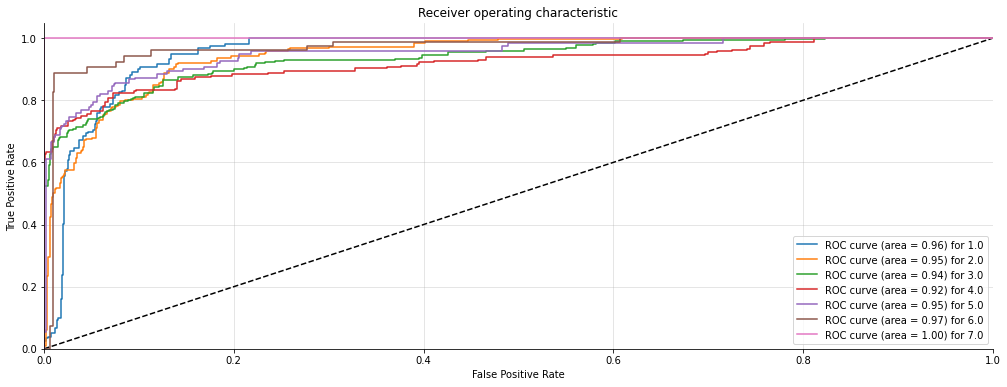

In [32]:
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def SVMmodel(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    svc = SVC( probability=True)
    svc.fit(X_train, y_train)

    # predictions over test set
    predictions=[round(float(x)) for x in svc.predict(X_test)]
    print((classification_report(y_test, predictions)))

    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(svc, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  SVMmodel(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [33]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE -score :{}".format(np.mean(rms)))
print("average auc score {}".format(np.mean(aucscore)))
metric_df['SVM'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.6655505952380952
average Precision :0.6922714948058465
average Recall :0.6655505952380952
average F1 -score :0.6631573423308237
average RMSE -score :1.4362684239507286
average auc score 0.8052569852971292


## 3.7. Custom-Built Ordinal Classifier

Credit: [Muhammad for Towards Data Science](https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c)

Ordinal classifier basically does a similar thing to one-hot encoding -- but despite having one value each column, ordinal encoding maps unique binary values for each of our unique classes.

We implement a custom object called `OrdinalClassifier` built on top of any `sklearn` model that supports the `predict_proba()` function; ranging from Naive Bayes to decision trees.

Last implementation, we deduced the labels by one, from `[1,2,3,4,5,6,7]` to `[0,1,2,3,4,5,6]` due to the nature of zero-indexing of standard sklearn library. But this doesn't work if the labels aren't ranging fully from 1 to 7 -- could be 2 to 6 or 2 to 7 instead.

So the solution is to change the overall behavior of the `OrdinalClassifier` object to take maximum class (e.g. 7) and minimum class (e.g. 2 or 3) into consideration. From there, we simulate the `np.argmax()` function to be added the minimum class before being returned. We also add the minimum class as an index towards `self.clfs` dictionary when adding new value, so we don't need to deduce the labels by hand. In other words, labels stay as-is instead of being deduced by 1 :)

This also changes how the approach for ordinal encoding works -- instead of `k - 1` like the author's original implementation, we feed `k` numbers of encoding because our labels are already one-indexed.

Keep in mind that the `predict_proba()` function does not yet implement this change, because it's only a wrapper function before eventually calling `predict()` in which we care the most about the result. 

For column: obstructive<==>supportive
[16:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:16] WARNING: C:/Users/Adm

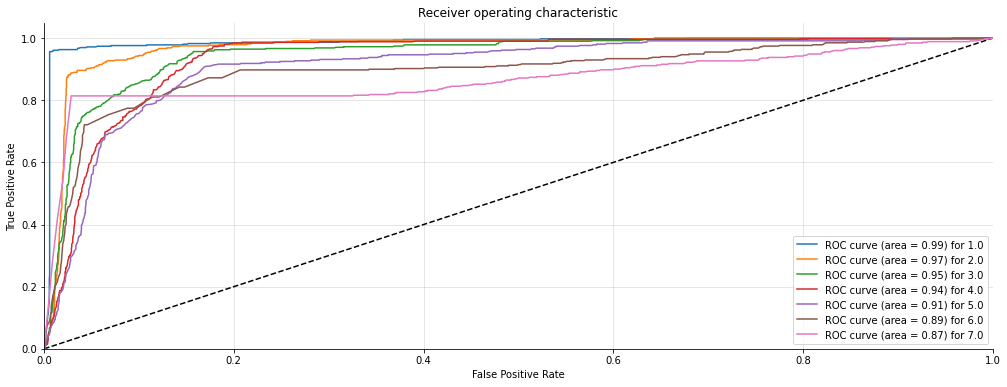

For column: complicated<==>easy
[16:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:18] WARNING: C:/Users/Administr

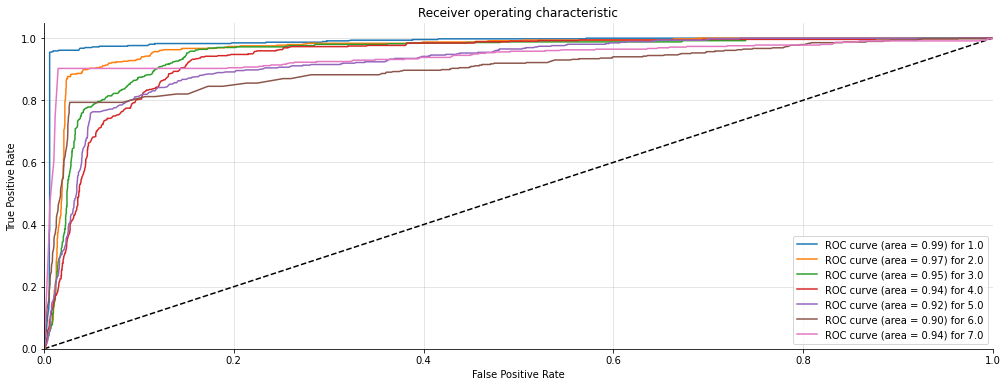

For column: inefficient<==>efficient
[16:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:20] WARNING: C:/Users/Admi

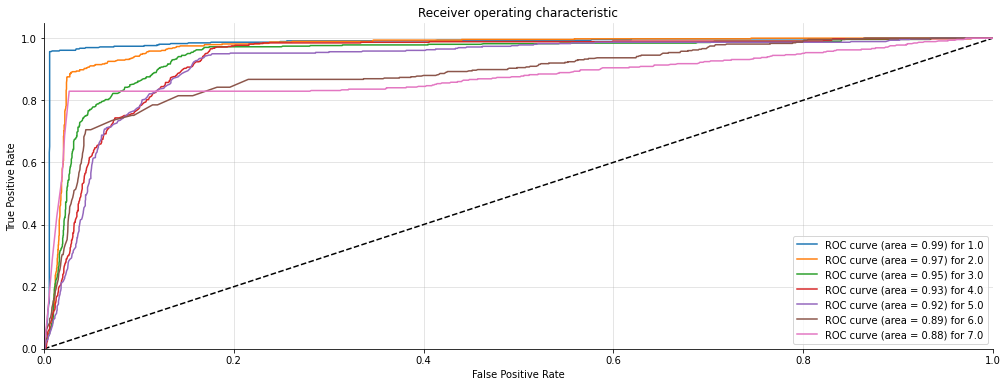

For column:  confusing<==>clear
[16:22:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:22] WARNING: C:/Users/Administr

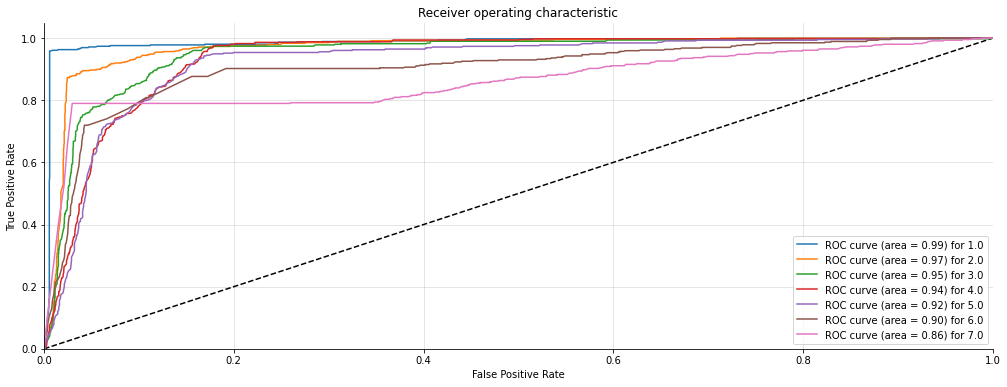

For column: boring<==>exciting
[16:22:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:24] WARNING: C:/Users/Administra

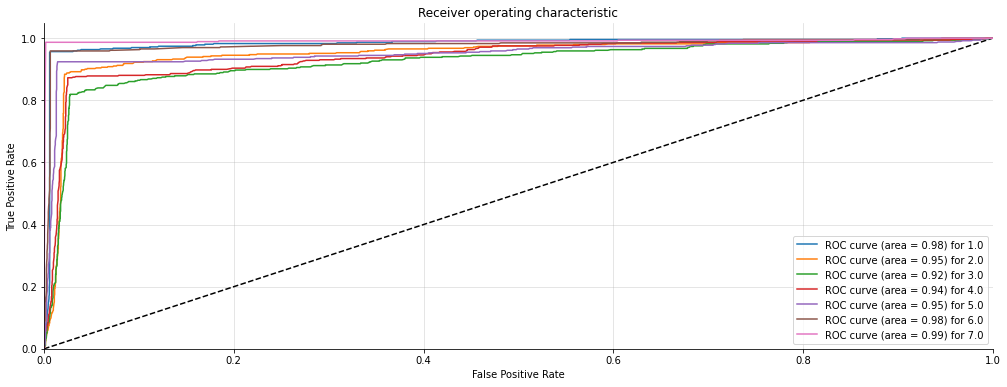

For column: not interesting<==>interesting
[16:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:26] WARNING: C:/User

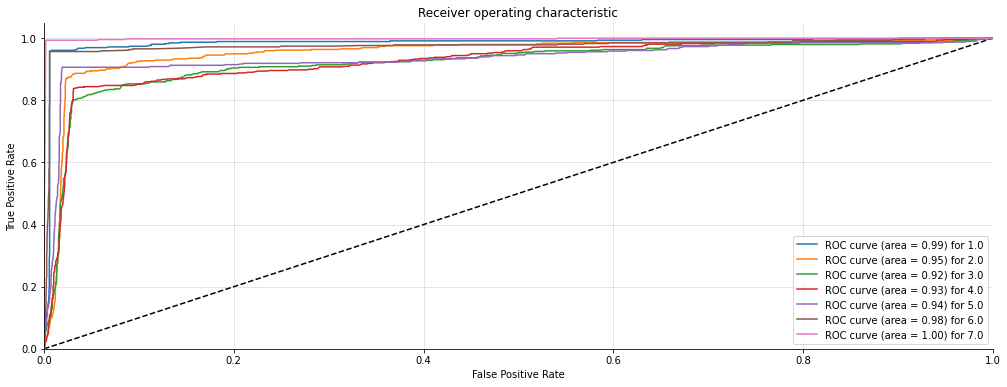

For column: conventional<==>inventive
[16:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:29] WARNING: C:/Users/Adm

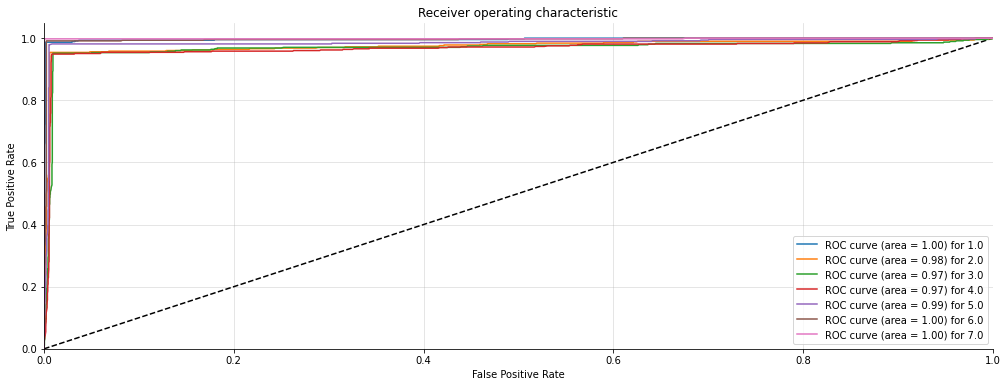

For column: usual<==>leading edge
[16:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:31] WARNING: C:/Users/Adminis

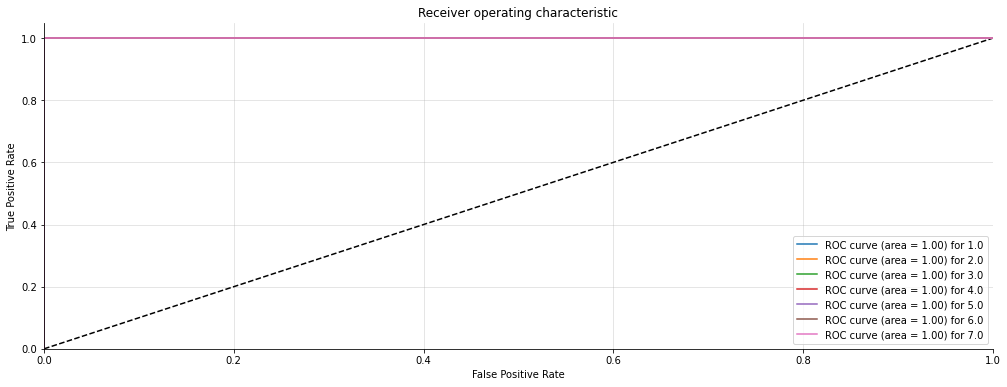

In [34]:
from sklearn.base import clone

acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        self.max_class = max(self.unique_class)
        self.min_class = min(self.unique_class)
        if self.unique_class.shape[0] > 2:
            # print(self.unique_class.shape[0]) # Uncomment to debug
            for i in range(self.unique_class.shape[0]):
                # for each k ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                
                
                clf.fit(X, binary_y)
                self.clfs[i + self.min_class] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        # print(self.clfs) # Uncomment to debug
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1) + self.min_class

def OrdinalModel(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    clf = OrdinalClassifier(XGBClassifier()) # Using XGB as the placeholder model 
    clf.fit(X_train, y_train)

    # predictions over test set
    predictions = clf.predict(X_test)
    print((classification_report(y_test, predictions)))

    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    aucscore.append(score_auc(y_test,predictions))

    plot_multiclass_roc(clf, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  OrdinalModel(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))
  #break # Uncomment to debug

In [35]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE -score :{}".format(np.mean(rms)))
print("average AUC score:{}".format(np.mean(aucscore)))
metric_df['OrdinalModel'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.8659598214285714
average Precision :0.8660386384516412
average Recall :0.8659598214285714
average F1 -score :0.8658904656913442
average RMSE -score :0.5960154097026645
average AUC score:0.9216290691448807


# 4. Other Deep Learning Model(s)

## 4.1. Bidirectional LSTM

In [35]:
## Callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
  "model_checkpoints", monitor="val_loss", verbose=1, save_best_only=True, mode="min")

## Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(2000, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(64, activation='relu', 
                          
                          # Prevent overfitting
                          kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), 

                          # Ensuring consistent outputs and not run into potential local optima
                          # Avoid initializing standard normal (mean = 0, std = 1) to reach faster convergence and less initial loss.
                          kernel_initializer=tf.keras.initializers.RandomNormal(seed=42)
                          
                          ),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation='linear')
])
LSTM_model.summary()

LSTM_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer= opt, metrics=['mae'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          128000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 520       
Total params: 202,824
Trainable params: 202,824
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = LSTM_model.fit(X_train, y_train, epochs=100, batch_size = 512, validation_split=0.2, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=1)

Epoch 1/100
21/21 [==============================] - 12s 236ms/step - loss: 17.5761 - mae: 3.6382 - val_loss: 6.3500 - val_mae: 2.0622
Epoch 2/100
21/21 [==============================] - 2s 112ms/step - loss: 5.8737 - mae: 1.9821 - val_loss: 4.3437 - val_mae: 1.7617
Epoch 3/100
21/21 [==============================] - 2s 112ms/step - loss: 4.9940 - mae: 1.8567 - val_loss: 3.8786 - val_mae: 1.6796
Epoch 4/100
21/21 [==============================] - 3s 123ms/step - loss: 4.3317 - mae: 1.7121 - val_loss: 2.9695 - val_mae: 1.4220
Epoch 5/100
21/21 [==============================] - 2s 119ms/step - loss: 2.8720 - mae: 1.3077 - val_loss: 1.4116 - val_mae: 0.8632
Epoch 6/100
21/21 [==============================] - 2s 112ms/step - loss: 1.8426 - mae: 1.0121 - val_loss: 1.0275 - val_mae: 0.6617
Epoch 7/100
21/21 [==============================] - 2s 111ms/step - loss: 1.5729 - mae: 0.9100 - val_loss: 0.9190 - val_mae: 0.6179
Epoch 8/100
21/21 [==============================] - 3s 121ms/step 

### 4.1.1. Interpretation

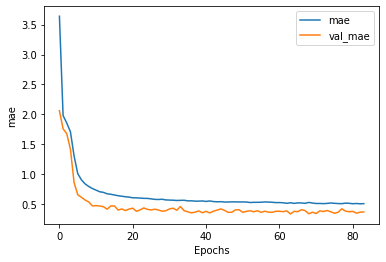

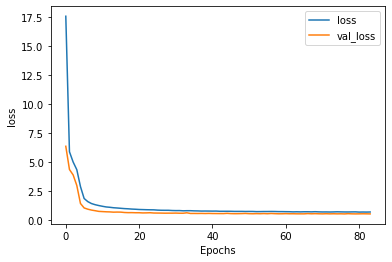

In [37]:
plot_graphs(history, "mae")
plot_graphs(history, "loss")

In [38]:
scores = LSTM_model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 5s 1ms/step - loss: 0.5187 - mae: 0.3745
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 51.87%
mae: 37.45%


In [39]:
history = LSTM_model.fit(X_train, y_train, epochs=100, batch_size = 512, validation_split=0.2, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=1)

Epoch 1/100
21/21 [==============================] - 1s 64ms/step - loss: 0.6704 - mae: 0.5121 - val_loss: 0.5122 - val_mae: 0.3567
Epoch 2/100
21/21 [==============================] - 1s 65ms/step - loss: 0.6756 - mae: 0.5130 - val_loss: 0.5154 - val_mae: 0.3588
Epoch 3/100
21/21 [==============================] - 1s 69ms/step - loss: 0.6673 - mae: 0.5112 - val_loss: 0.5144 - val_mae: 0.3601
Epoch 4/100
21/21 [==============================] - 1s 66ms/step - loss: 0.6646 - mae: 0.5063 - val_loss: 0.5215 - val_mae: 0.3524
Epoch 5/100
21/21 [==============================] - 1s 69ms/step - loss: 0.6693 - mae: 0.5109 - val_loss: 0.5178 - val_mae: 0.3785
Epoch 6/100
21/21 [==============================] - 2s 72ms/step - loss: 0.6633 - mae: 0.5067 - val_loss: 0.5213 - val_mae: 0.3420
Epoch 7/100
21/21 [==============================] - 1s 62ms/step - loss: 0.6536 - mae: 0.4999 - val_loss: 0.5151 - val_mae: 0.3825
Epoch 8/100
21/21 [==============================] - 1s 69ms/step - loss: 0.

# Result

In [41]:
LSTM_y_pred = LSTM_model.predict(X_test)
LSTM_y_pred_flattened = LSTM_y_pred.flatten(order='F')
LSTM_y_classified = [round(float(x)) for x in LSTM_y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test_flattened[:10])
print("Predicted labels:",LSTM_y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test_flattened, LSTM_y_classified))

First ten examples of the test set:
Truth labels: [2. 1. 2. 1. 4. 3. 4. 3. 3. 7.]
Predicted labels: [2, 1, 2, 1, 5, 4, 4, 3, 4, 1]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       0.97      0.96      0.96      3691
         2.0       0.86      0.73      0.79      3921
         3.0       0.69      0.72      0.71      3952
         4.0       0.74      0.80      0.77      4161
         5.0       0.79      0.84      0.81      3786
         6.0       0.87      0.85      0.86      3748
         7.0       0.92      0.91      0.92      3621

    accuracy                           0.83     26880
   macro avg       0.83      0.83      0.83     26880
weighted avg       0.83      0.83      0.83     26880



## 4.2. BERT [deprecated]

In [42]:
"""!pip install -q -U tensorflow-text
!pip install -q tf-models-official
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

to_handle = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
to_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_model = hub.KerasLayer(to_preprocess)

text_test = ['this is such an amazing movie!']
text_preprocessed = bert_model(text_test)

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(to_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(to_handle, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
print(f'Training model with {to_handle}')
history = classifier_model.fit(X_train, y_train)"""

"!pip install -q -U tensorflow-text\n!pip install -q tf-models-official\nimport tensorflow_hub as hub\nimport tensorflow_text as text\nfrom official.nlp import optimization  # to create AdamW optimizer\n\nto_handle = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'\nto_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'\nbert_model = hub.KerasLayer(to_preprocess)\n\ntext_test = ['this is such an amazing movie!']\ntext_preprocessed = bert_model(text_test)\n\ndef build_classifier_model():\n  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')\n  preprocessing_layer = hub.KerasLayer(to_preprocess, name='preprocessing')\n  encoder_inputs = preprocessing_layer(text_input)\n  encoder = hub.KerasLayer(to_handle, trainable=True, name='BERT_encoder')\n  outputs = encoder(encoder_inputs)\n  net = outputs['pooled_output']\n  net = tf.keras.layers.Dropout(0.1)(net)\n  net = tf.keras.layers.Dense(1, activation=None, name='classifi

# 4.3 RBFN

In [43]:

from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras.initializers import RandomUniform, Initializer, Constant
import numpy as np

In [44]:
class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]
        print("done")
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

from keras.initializers import Initializer
from sklearn.cluster import KMeans


class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_


In [45]:
import numpy as np, pandas as pd
from keras.models import Sequential 
from keras.layers.core import Dense
from keras.layers import Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

In [46]:
model = Sequential()
rbflayer = RBFLayer(100,
                        initializer=InitCentersKMeans(X_train),
                        betas=3.0,
                        input_shape=(X_train.shape[1],))
model.add(rbflayer)
model.add(Dense(8))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error',
                  optimizer='adam', metrics=['accuracy'])
model.build(X_train.shape)
print(model.summary())
history1 = model.fit(X_train, y_train, epochs=100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (13440, 100)              2100      
_________________________________________________________________
dense (Dense)                (13440, 8)                808       
_________________________________________________________________
activation (Activation)      (13440, 8)                0         
Total params: 2,908
Trainable params: 2,908
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
420/420 [==============================] - 12s 957us/step - loss: 19.2708 - accuracy: 0.0752
Epoch 2/100
420/420 [==============================] - 0s 858us/step - loss: 16.2065 - accuracy: 0.0469
Epoch 3/100
420/420 [==============================] - 0s 842us/step - loss: 13.6795 - accuracy: 0.0415
Epoch 4/100
420/420 [==============================] - 0s 859us/st

In [47]:
y_train.shape

(13440, 8)

In [48]:
LSTM_y_pred = model.predict(X_test)
LSTM_y_pred_flattened = LSTM_y_pred.flatten(order='F')
LSTM_y_classified = [round(float(x)) for x in LSTM_y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test[:10])
print("Predicted labels:",LSTM_y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test.flatten(order='F'), LSTM_y_classified))

First ten examples of the test set:
Truth labels: [[2. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [4. 4. 4. 4. 5. 5. 5. 5.]
 [3. 3. 3. 3. 3. 3. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 4. 4.]
 [7. 7. 7. 7. 2. 2. 1. 1.]]
Predicted labels: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       1.00      0.01      0.01      3691
         2.0       0.00      0.00      0.00      3921
         3.0       1.00      0.00      0.01      3952
         4.0       0.16      1.00      0.28      4161
         5.0       0.91      0.02      0.04      3786
         6.0       0.92      0.06      0.11      3748
         7.0       0.92      0.16      0.28      3621

    accuracy                           0.19     26880
   macro avg       0.70      0.18      0.10     26880
weighted avg       0.69      0.19      0.11     268

In [49]:
from sklearn.metrics import classification_report

In [50]:
X_test.shape

(3360, 20)

In [51]:
y_test.shape

(3360, 8)

# 4.4 Multiclass Logistic regression

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.20      0.47      0.28       462
         2.0       0.21      0.17      0.19       482
         3.0       0.25      0.07      0.12       510
         4.0       0.34      0.19      0.24       517
         5.0       0.24      0.15      0.18       467
         6.0       0.16      0.13      0.15       470
         7.0       0.48      0.85      0.61       452

    accuracy                           0.28      3360
   macro avg       0.27      0.29      0.25      3360
weighted avg       0.27      0.28      0.25      3360

Confusion Matrix: 
 [[215  54  14   9  39  62  69]
 [182  81  13  29  44  60  73]
 [142  76  38  62  43  83  66]
 [141  68  37  96  61  58  56]
 [177  58  32  53  69  47  31]
 [175  43  10  30  27  63 122]
 [ 27  13   6   4   7  12 383]]
Accuracy Score : 0.28125
Precision Score : 0.2684927146815615
Recall Score : 0.28125
F1 Score : 0.2480944285707605
(3360, 7) (3

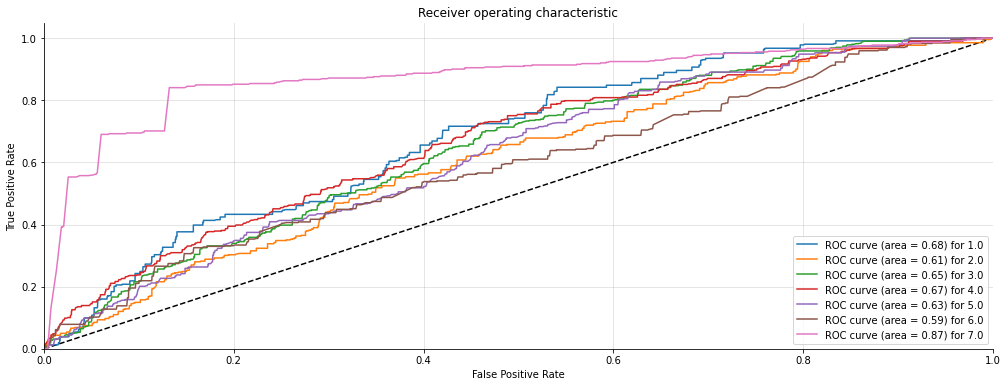

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.32      0.21      0.26       463
         2.0       0.23      0.22      0.22       485
         3.0       0.24      0.11      0.15       501
         4.0       0.23      0.16      0.19       515
         5.0       0.23      0.27      0.25       460
         6.0       0.25      0.34      0.29       484
         7.0       0.53      0.92      0.67       452

    accuracy                           0.31      3360
   macro avg       0.29      0.32      0.29      3360
weighted avg       0.29      0.31      0.29      3360

Confusion Matrix: 
 [[ 99  71  19  34  75  88  77]
 [ 44 108  32  66  66  98  71]
 [ 36  75  54  83  77 122  54]
 [ 31  98  53  84 109  94  46]
 [ 45  70  43  56 126  93  27]
 [ 48  49  19  26  84 165  93]
 [  4   6   2  10   6   9 415]]
Accuracy Score : 0.31279761904761905
Precision Score : 0.2878458538013911
Recall Score : 0.31279761904761905
F1 Score : 0.28561271606

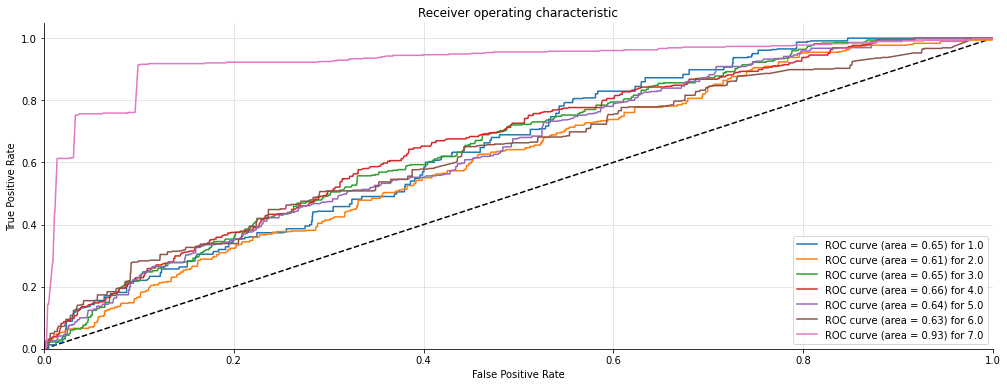

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.22      0.50      0.31       462
         2.0       0.20      0.15      0.17       482
         3.0       0.24      0.08      0.12       506
         4.0       0.33      0.17      0.23       526
         5.0       0.23      0.14      0.17       458
         6.0       0.22      0.20      0.21       475
         7.0       0.49      0.85      0.62       451

    accuracy                           0.29      3360
   macro avg       0.28      0.30      0.26      3360
weighted avg       0.27      0.29      0.26      3360

Confusion Matrix: 
 [[233  41  19  11  34  59  65]
 [184  71  16  27  48  61  75]
 [143  69  42  61  40  91  60]
 [147  68  46  91  55  65  54]
 [175  54  36  50  62  53  28]
 [146  50   9  30  23  97 120]
 [ 29  11   7   3   9   9 383]]
Accuracy Score : 0.29136904761904764
Precision Score : 0.2748139115243422
Recall Score : 0.29136904761904764
F1 Score : 0.257004

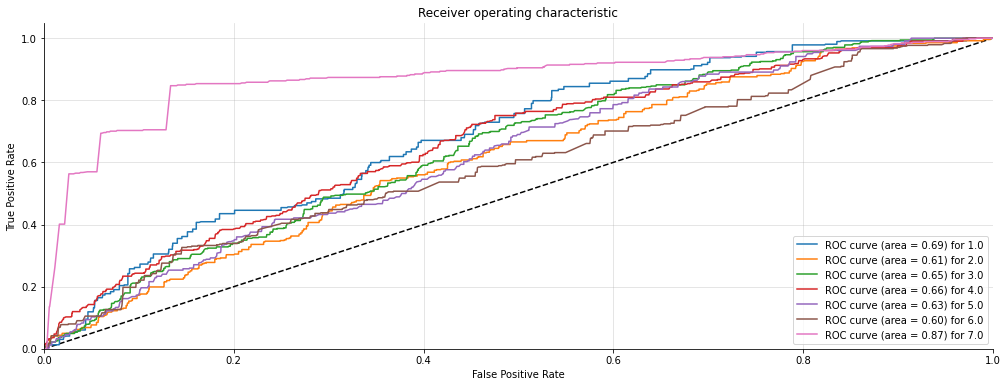

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.22      0.51      0.31       461
         2.0       0.20      0.15      0.18       488
         3.0       0.25      0.09      0.13       506
         4.0       0.33      0.17      0.22       516
         5.0       0.24      0.14      0.18       456
         6.0       0.23      0.20      0.22       471
         7.0       0.48      0.81      0.60       462

    accuracy                           0.29      3360
   macro avg       0.28      0.30      0.26      3360
weighted avg       0.28      0.29      0.26      3360

Confusion Matrix: 
 [[236  41  22  11  31  55  65]
 [187  75  15  28  48  59  76]
 [140  70  45  60  43  83  65]
 [145  68  46  87  58  57  55]
 [176  52  38  44  66  54  26]
 [142  49   8  26  23  96 127]
 [ 36  13   8   9   7  14 375]]
Accuracy Score : 0.2916666666666667
Precision Score : 0.2777416982120529
Recall Score : 0.2916666666666667
F1 Score : 0.2590678709941

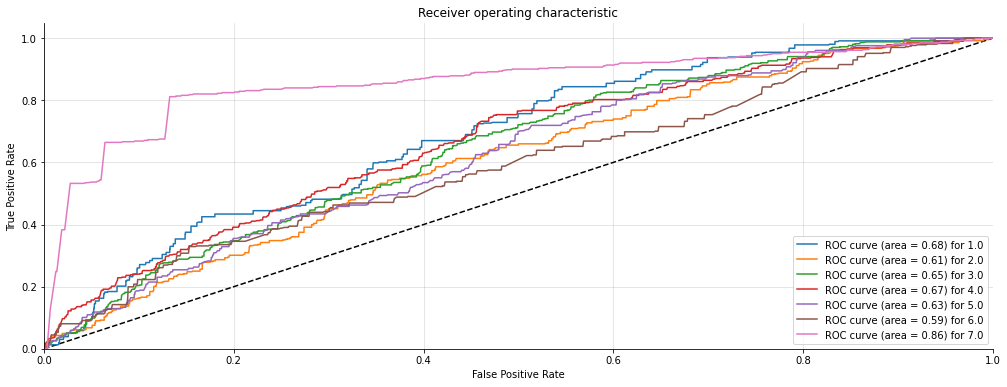

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.30      0.17      0.21       463
         2.0       0.23      0.19      0.21       491
         3.0       0.21      0.12      0.15       487
         4.0       0.21      0.14      0.17       518
         5.0       0.27      0.34      0.30       487
         6.0       0.31      0.53      0.39       462
         7.0       0.69      0.99      0.81       452

    accuracy                           0.35      3360
   macro avg       0.32      0.35      0.32      3360
weighted avg       0.31      0.35      0.31      3360

Confusion Matrix: 
 [[ 77  54  42  41  86 106  57]
 [ 38  94  46  63 106 101  43]
 [ 34  51  59  80 110 125  28]
 [ 29  89  71  74 105 128  22]
 [ 21  69  54  62 167  91  23]
 [ 55  46  15  25  45 244  32]
 [  1   1   0   1   0   2 447]]
Accuracy Score : 0.3458333333333333
Precision Score : 0.3118044899885857
Recall Score : 0.3458333333333333
F1 Score : 0.31475794890078

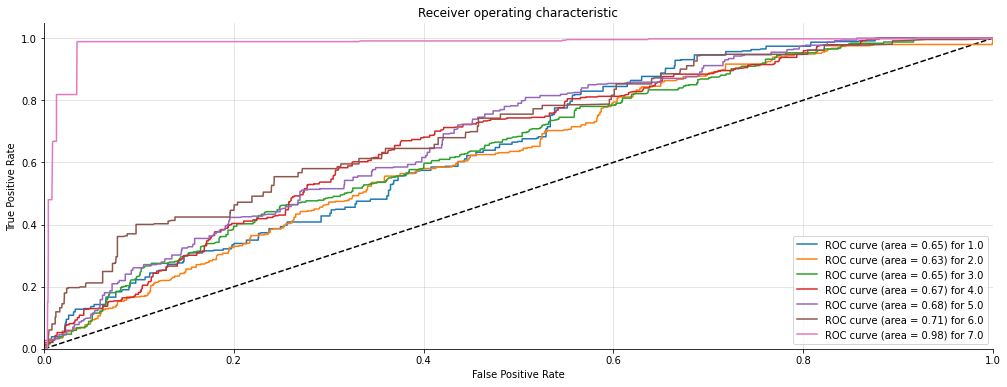

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.30      0.17      0.22       461
         2.0       0.24      0.19      0.21       495
         3.0       0.18      0.10      0.13       490
         4.0       0.23      0.16      0.19       519
         5.0       0.27      0.36      0.31       481
         6.0       0.30      0.51      0.38       465
         7.0       0.69      1.00      0.81       449

    accuracy                           0.35      3360
   macro avg       0.32      0.35      0.32      3360
weighted avg       0.31      0.35      0.31      3360

Confusion Matrix: 
 [[ 80  58  35  45  82 105  56]
 [ 43  92  37  63 111 103  46]
 [ 32  48  49  78 113 136  34]
 [ 25  83  69  82 114 122  24]
 [ 22  47  55  69 172  96  20]
 [ 67  53  23  16  46 239  21]
 [  1   0   0   0   0   1 447]]
Accuracy Score : 0.3455357142857143
Precision Score : 0.31078683412118063
Recall Score : 0.3455357142857143
F1 Score : 0.3

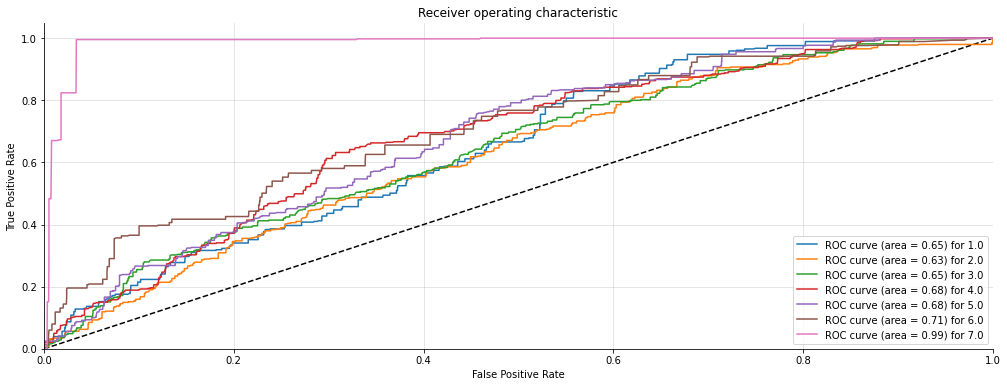

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.26      0.13      0.18       460
         2.0       0.25      0.18      0.21       502
         3.0       0.19      0.12      0.14       474
         4.0       0.22      0.16      0.19       527
         5.0       0.29      0.40      0.34       486
         6.0       0.30      0.53      0.39       459
         7.0       0.73      1.00      0.84       452

    accuracy                           0.35      3360
   macro avg       0.32      0.36      0.33      3360
weighted avg       0.31      0.35      0.32      3360

Confusion Matrix: 
 [[ 62  51  50  58  80 109  50]
 [ 39  89  49  74 119  95  37]
 [ 20  48  55  78 110 136  27]
 [ 29  71  70  85 118 137  17]
 [ 21  50  55  62 192  85  21]
 [ 70  53  17  24  32 244  19]
 [  0   0   0   1   0   0 451]]
Accuracy Score : 0.35059523809523807
Precision Score : 0.3146203732823259
Recall Score : 0.35059523809523807
F1 Score : 0.31901

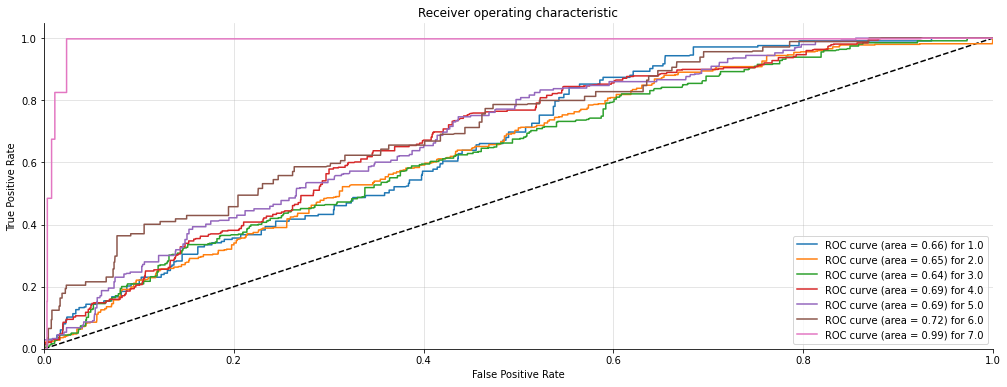

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.26      0.14      0.18       459
         2.0       0.25      0.19      0.21       496
         3.0       0.23      0.16      0.19       478
         4.0       0.26      0.19      0.22       523
         5.0       0.28      0.38      0.32       491
         6.0       0.31      0.52      0.39       462
         7.0       0.75      1.00      0.86       451

    accuracy                           0.36      3360
   macro avg       0.33      0.37      0.34      3360
weighted avg       0.33      0.36      0.33      3360

Confusion Matrix: 
 [[ 62  49  56  56  84 110  42]
 [ 44  93  47  71 115  93  33]
 [ 19  43  75  69 126 120  26]
 [ 30  82  64  99 112 124  12]
 [ 20  53  64  65 186  87  16]
 [ 62  54  25  19  41 242  19]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.3595238095238095
Precision Score : 0.3302142468720387
Recall Score : 0.3595238095238095
F1 Score : 0.33257176978

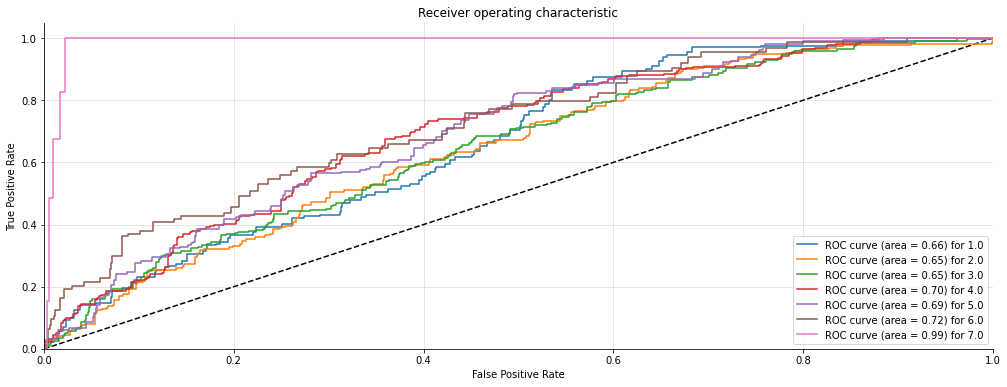

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def Logistic(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs')   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  Logistic(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [37]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE :{}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['LogisticModel'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.3223214285714286
average Precision :0.2970400153104348
average Recall :0.3223214285714286
average F1 -score :0.2912655109632055
average RMSE :2.4609120415089967
average AUC score 0.6051370847491607


# 4.5 Neural network - classifier

In [54]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

initializer = tf.keras.initializers.RandomNormal(seed=1) # Reproducibility

model = Sequential(name="classifier_NN")
model.add(tf.keras.Input(shape=(X_train.shape[1],))) # Automatically detect features as input nodes
model.add(layers.Dense(512, activation='relu', kernel_initializer=initializer))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dense(64, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(8)) # output layer
opt = tf.keras.optimizers.Adam(learning_rate = 0.0003)
model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'], optimizer = opt)
model.summary()

Model: "classifier_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               10752     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 128)             

Epoch 1/150
588/588 - 1s - loss: 5.1614 - mae: 1.7584 - val_loss: 3.3165 - val_mae: 1.3609
Epoch 2/150
588/588 - 1s - loss: 2.8322 - mae: 1.2961 - val_loss: 2.0812 - val_mae: 1.1252
Epoch 3/150
588/588 - 1s - loss: 2.0169 - mae: 1.0872 - val_loss: 1.4167 - val_mae: 0.9008
Epoch 4/150
588/588 - 1s - loss: 1.5939 - mae: 0.9634 - val_loss: 1.2522 - val_mae: 0.8544
Epoch 5/150
588/588 - 1s - loss: 1.3990 - mae: 0.8978 - val_loss: 0.9200 - val_mae: 0.6940
Epoch 6/150
588/588 - 1s - loss: 1.2856 - mae: 0.8503 - val_loss: 1.0460 - val_mae: 0.7656
Epoch 7/150
588/588 - 1s - loss: 1.1820 - mae: 0.8054 - val_loss: 1.0113 - val_mae: 0.7442
Epoch 8/150
588/588 - 1s - loss: 1.1145 - mae: 0.7695 - val_loss: 1.1999 - val_mae: 0.8398
Epoch 9/150
588/588 - 1s - loss: 1.0535 - mae: 0.7428 - val_loss: 0.8129 - val_mae: 0.6573
Epoch 10/150
588/588 - 1s - loss: 0.9899 - mae: 0.7101 - val_loss: 0.9665 - val_mae: 0.7286
Epoch 11/150
588/588 - 1s - loss: 0.9495 - mae: 0.6877 - val_loss: 0.9025 - val_mae: 0.70

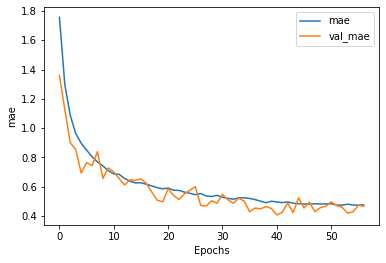

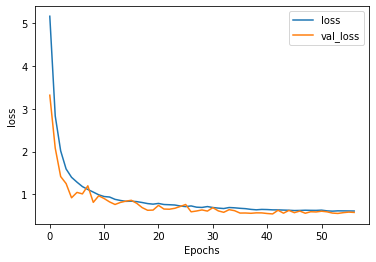

In [55]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(X_train, y_train, epochs=150, batch_size = 16, validation_split=0.3, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=2)

plot_graphs(history, "mae")
plot_graphs(history, "loss")

In [56]:
scores = model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 2s 706us/step - loss: 0.5854 - mae: 0.4653
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 58.54%
mae: 46.53%


# 4.6 LSTM 

In [57]:
## Callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
  "model_checkpoints", monitor="val_loss", verbose=1, save_best_only=True, mode="min")

## Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(4000, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(64, activation='relu', 
                          
                          # Prevent overfitting
                          kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), 

                          # Ensuring consistent outputs and not run into potential local optima
                          # Avoid initializing standard normal (mean = 0, std = 1) to reach faster convergence and less initial loss.
                          kernel_initializer=tf.keras.initializers.RandomNormal(seed=42)
                          
                          ),
     
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='linear')
])
LSTM_model.summary()

LSTM_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer= opt, metrics=['mae'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         512000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_18 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 520       
Total params: 792,136
Trainable params: 792,136
Non-trainable params: 0
_________________________________________________________________


In [58]:
history = LSTM_model.fit(X_train, y_train, epochs=100, batch_size = 512, validation_split=0.2, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=1)

Epoch 1/100
21/21 [==============================] - 6s 216ms/step - loss: 13.7031 - mae: 3.0699 - val_loss: 4.3484 - val_mae: 1.7312
Epoch 2/100
21/21 [==============================] - 4s 198ms/step - loss: 5.3656 - mae: 1.8991 - val_loss: 4.2000 - val_mae: 1.7219
Epoch 3/100
21/21 [==============================] - 4s 194ms/step - loss: 4.9195 - mae: 1.8392 - val_loss: 4.0682 - val_mae: 1.7041
Epoch 4/100
21/21 [==============================] - 4s 194ms/step - loss: 4.7185 - mae: 1.8089 - val_loss: 3.8784 - val_mae: 1.6604
Epoch 5/100
21/21 [==============================] - 4s 198ms/step - loss: 4.4014 - mae: 1.7468 - val_loss: 3.6038 - val_mae: 1.6060
Epoch 6/100
21/21 [==============================] - 4s 195ms/step - loss: 3.6897 - mae: 1.5695 - val_loss: 2.4176 - val_mae: 1.2018
Epoch 7/100
21/21 [==============================] - 4s 194ms/step - loss: 2.3514 - mae: 1.1720 - val_loss: 1.3749 - val_mae: 0.8117
Epoch 8/100
21/21 [==============================] - 4s 203ms/step -

21/21 [==============================] - 4s 202ms/step - loss: 0.6660 - mae: 0.5037 - val_loss: 0.5318 - val_mae: 0.3923
Epoch 63/100
21/21 [==============================] - 4s 203ms/step - loss: 0.6635 - mae: 0.5039 - val_loss: 0.5206 - val_mae: 0.3774
Epoch 64/100
21/21 [==============================] - 4s 203ms/step - loss: 0.6589 - mae: 0.4952 - val_loss: 0.5213 - val_mae: 0.3896
Epoch 65/100
21/21 [==============================] - 4s 203ms/step - loss: 0.6548 - mae: 0.4980 - val_loss: 0.5374 - val_mae: 0.4248
Epoch 66/100
21/21 [==============================] - 4s 203ms/step - loss: 0.6646 - mae: 0.5004 - val_loss: 0.5191 - val_mae: 0.3758
Epoch 00066: early stopping


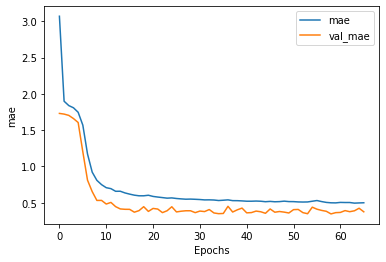

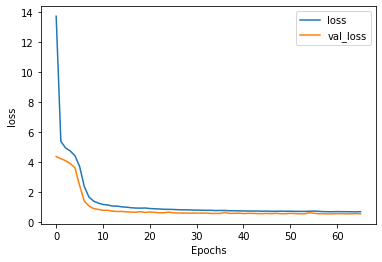

In [59]:
plot_graphs(history, "mae")
plot_graphs(history, "loss")

In [60]:
scores = LSTM_model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 6s 2ms/step - loss: 0.5252 - mae: 0.3763
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 52.52%
mae: 37.63%


# 4.7 Ensemble

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


# 4.7.1 Decison tree classifier

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.84      0.89      0.86       482
         3.0       0.77      0.74      0.75       510
         4.0       0.68      0.68      0.68       517
         5.0       0.64      0.66      0.65       467
         6.0       0.73      0.71      0.72       470
         7.0       0.82      0.81      0.82       452

    accuracy                           0.78      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.78      0.78      0.77      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  2 428  50   0   1   1   0]
 [  0  10 375 120   2   3   0]
 [  0   1  20 352 143   1   0]
 [  4   5  13  27 307 111   0]
 [  3  20   9  11  11 333  83]
 [ 10  27  20  10  12   5 368]]
Accuracy Score : 0.7752976190476191
Precision Score : 0.7750285373844749
Recall Score : 0.7752976190476191
F1 Score : 0.7749570

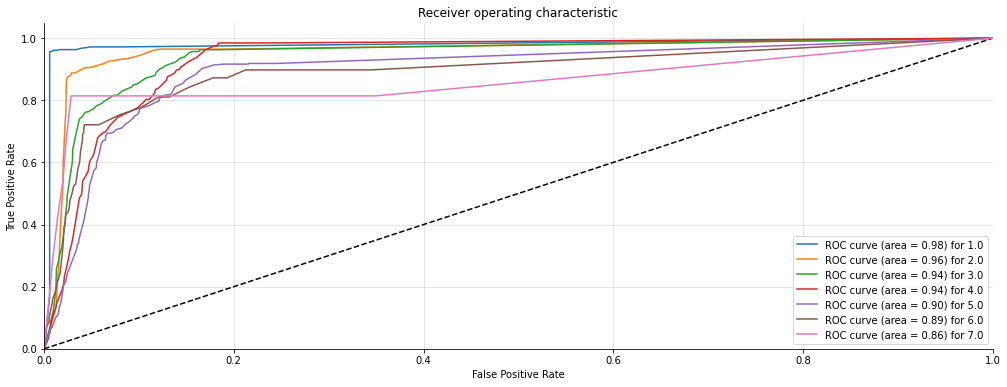

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.84      0.88      0.86       485
         3.0       0.77      0.75      0.76       501
         4.0       0.70      0.69      0.70       515
         5.0       0.71      0.74      0.72       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.81      3360
   macro avg       0.82      0.82      0.82      3360
weighted avg       0.81      0.81      0.81      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  2 428  51   0   1   3   0]
 [  0   9 376 114   2   0   0]
 [  0   2  29 356 126   2   0]
 [  3  13  16  18 340  70   0]
 [  5  19  13  14   6 384  43]
 [  9  19   5   4   5   2 408]]
Accuracy Score : 0.8136904761904762
Precision Score : 0.813908843576547
Recall Score : 0.8136904761904762
F1 Score : 0.81359006557159

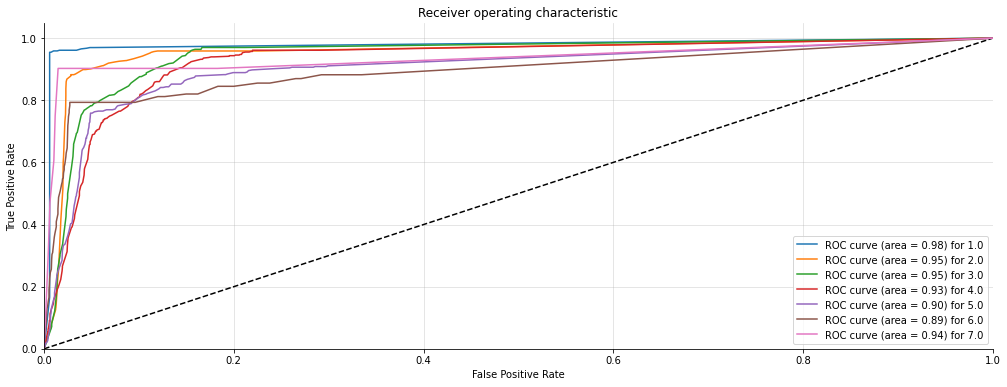

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.84      0.89      0.86       482
         3.0       0.76      0.74      0.75       506
         4.0       0.69      0.67      0.68       526
         5.0       0.65      0.68      0.66       458
         6.0       0.72      0.69      0.71       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.78      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.78      0.78      0.78      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  2 429  50   0   1   0   0]
 [  0   9 375 118   1   3   0]
 [  0   2  27 352 145   0   0]
 [  2   5   6  19 310 116   0]
 [  6  19  19  12  13 329  77]
 [  9  28  15  11   9   5 374]]
Accuracy Score : 0.7770833333333333
Precision Score : 0.77664743594845
Recall Score : 0.7770833333333333
F1 Score : 0.7766213120

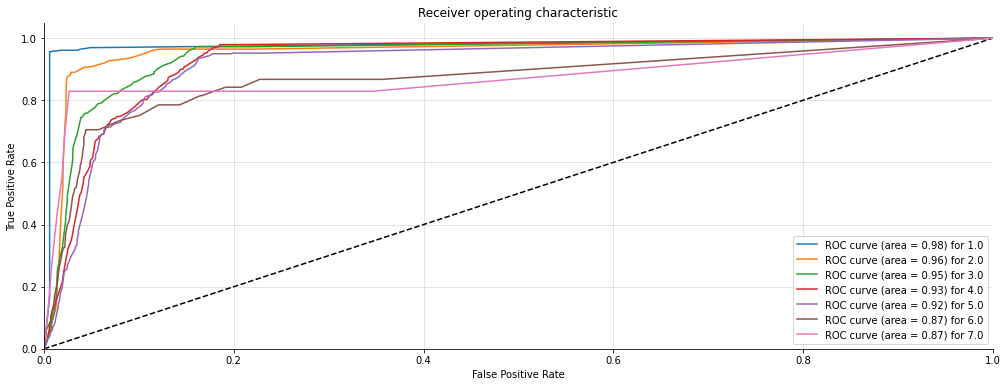

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.84      0.88      0.86       488
         3.0       0.76      0.75      0.75       506
         4.0       0.67      0.67      0.67       516
         5.0       0.65      0.68      0.66       456
         6.0       0.73      0.71      0.72       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  2 428  52   1   2   3   0]
 [  0   9 377 119   0   1   0]
 [  0   0  24 346 145   1   0]
 [  2   2   8  24 308 112   0]
 [  2  15  17   8  10 333  86]
 [ 13  35  20  16   9   4 365]]
Accuracy Score : 0.7735119047619048
Precision Score : 0.7735796232705643
Recall Score : 0.7735119047619048
F1 Score : 0.7734040926347

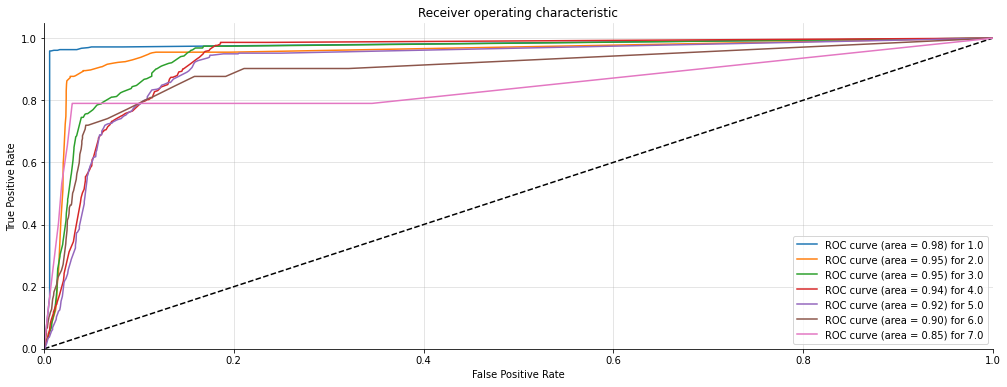

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.87      0.88      0.88       491
         3.0       0.83      0.82      0.82       487
         4.0       0.86      0.87      0.87       518
         5.0       0.92      0.92      0.92       487
         6.0       0.96      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  5 434  46   2   1   3   0]
 [  7  23 397  58   2   0   0]
 [  3  15  15 452  32   1   0]
 [  1   5  11   9 450  11   0]
 [  1   3   4   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9119047619047619
Precision Score : 0.9118831910801829
Recall Score : 0.9119047619047619
F1 Score : 0.91186398717164

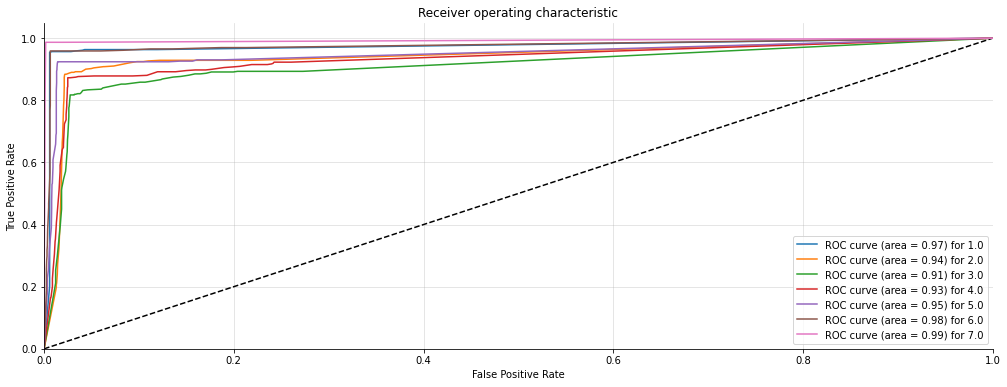

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.86      0.87      0.87       495
         3.0       0.82      0.79      0.81       490
         4.0       0.83      0.84      0.83       519
         5.0       0.89      0.91      0.90       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  5 433  49   2   2   4   0]
 [  7  27 386  69   0   1   0]
 [  3  17  17 435  47   0   0]
 [  1   8  10  15 436  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.899702380952381
Precision Score : 0.8995060229208637
Recall Score : 0.899702380952381
F1 Score : 0.8995

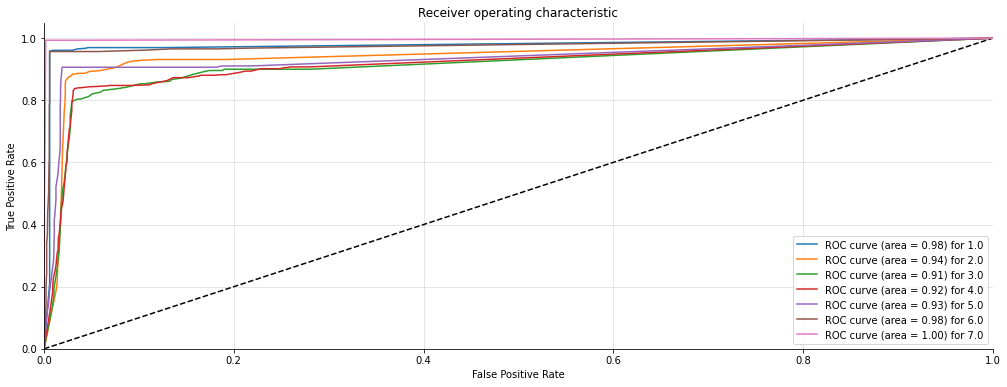

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.96      0.95      0.96       502
         3.0       0.94      0.95      0.95       474
         4.0       0.96      0.95      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  5 479  15   2   1   0   0]
 [  0  11 450  13   0   0   0]
 [  0   1  12 500  10   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9717261904761905
Precision Score : 0.9717262283839122
Recall Score : 0.9717261904761905
F1 Score : 0.9717136

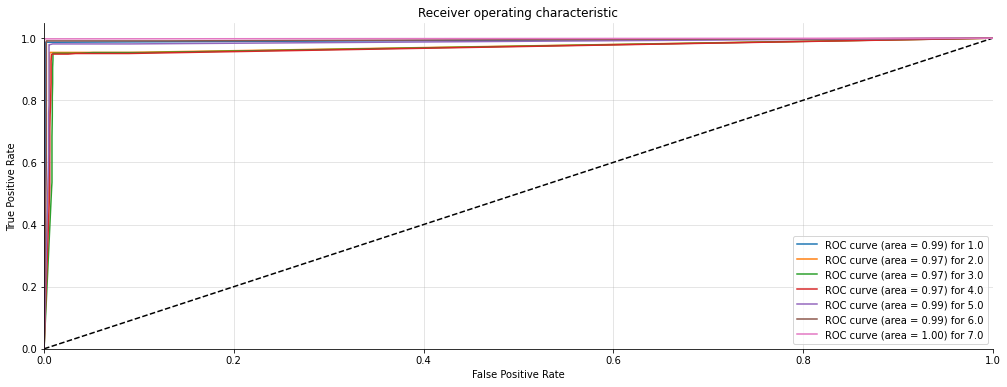

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0]
 [  0   0 478   0   0   0   0]
 [  0   0   0 523   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
(3360, 7) (3360, 7)


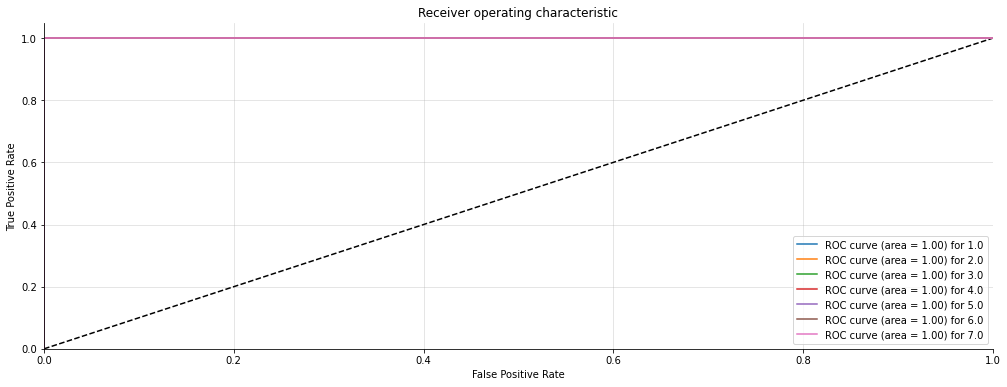

In [39]:
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def DTC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = DecisionTreeClassifier(max_depth=None, min_samples_split=2,
     random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    aucscore.append(score_auc(y_test,predictions))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))


    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  DTC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [40]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE :{}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['DecisionTreeclasssifier'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.8653645833333333
average Precision :0.8652849853206244
average Recall :0.8653645833333333
average F1 -score :0.8652083953704663
average RMSE :0.5960714608720428
average AUC score 0.9212798822165161


# 4.7.2 Random forest classifier

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.84      0.89      0.86       482
         3.0       0.78      0.74      0.76       510
         4.0       0.68      0.68      0.68       517
         5.0       0.64      0.66      0.65       467
         6.0       0.73      0.71      0.72       470
         7.0       0.81      0.81      0.81       452

    accuracy                           0.78      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.78      0.78      0.78      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  0 427  49   0   3   1   2]
 [  0   8 377 120   2   3   0]
 [  0   1  16 354 145   1   0]
 [  4   4  14  25 309 111   0]
 [  3  20   9  11  11 333  83]
 [ 10  27  20  10  12   5 368]]
Accuracy Score : 0.7767857142857143
Precision Score : 0.7769438935353301
Recall Score : 0.7767857142857143
F1 Score : 0.7766576

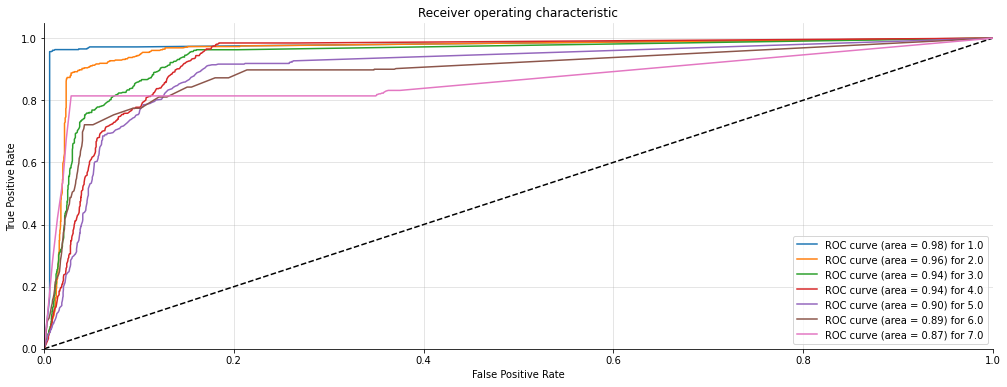

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.84      0.88      0.86       485
         3.0       0.77      0.75      0.76       501
         4.0       0.71      0.69      0.70       515
         5.0       0.71      0.75      0.73       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.82      3360
   macro avg       0.82      0.82      0.82      3360
weighted avg       0.82      0.82      0.82      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  0 427  50   1   3   3   1]
 [  0   7 378 114   2   0   0]
 [  0   2  27 357 127   2   0]
 [  3  13  16  15 343  70   0]
 [  5  19  13  14   6 384  43]
 [  9  18   6   4   5   2 408]]
Accuracy Score : 0.8151785714285714
Precision Score : 0.8156611456076704
Recall Score : 0.8151785714285714
F1 Score : 0.8151988296665

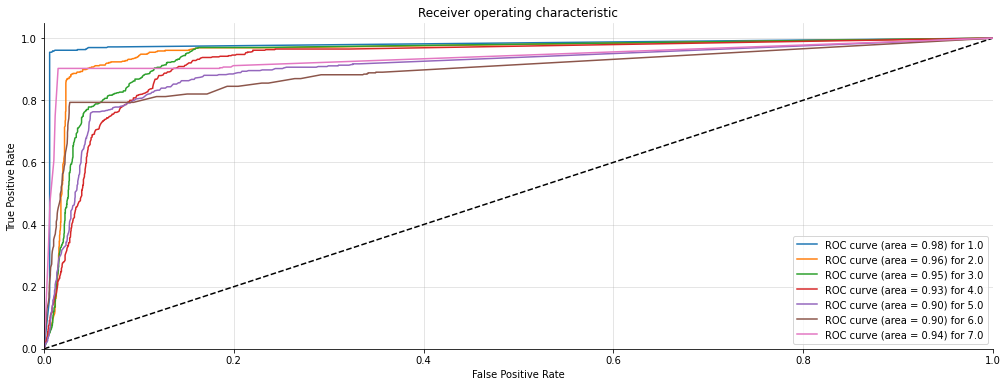

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.84      0.89      0.87       482
         3.0       0.77      0.75      0.76       506
         4.0       0.69      0.67      0.68       526
         5.0       0.64      0.68      0.66       458
         6.0       0.72      0.69      0.71       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.78      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.78      0.78      0.78      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  0 428  50   0   3   0   1]
 [  0   7 377 118   1   3   0]
 [  0   2  23 353 148   0   0]
 [  2   4   7  17 312 116   0]
 [  6  19  19  12  13 329  77]
 [  9  28  15  11   9   5 374]]
Accuracy Score : 0.7782738095238095
Precision Score : 0.7782973269754353
Recall Score : 0.7782738095238095
F1 Score : 0.77802602

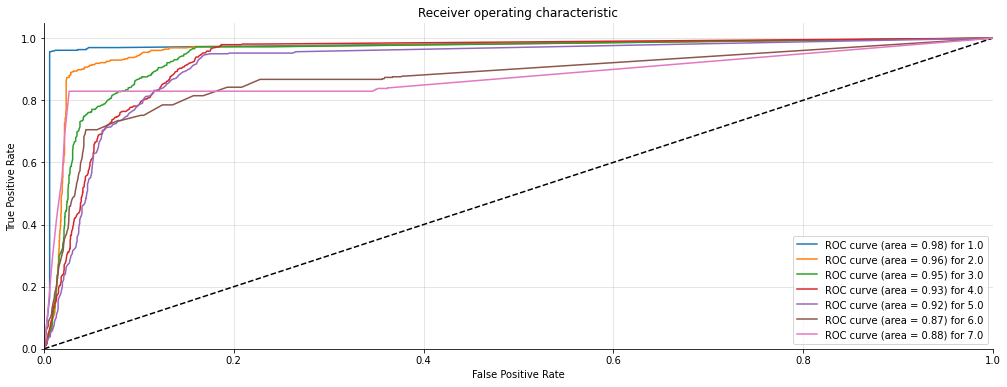

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.84      0.88      0.86       488
         3.0       0.77      0.74      0.76       506
         4.0       0.68      0.68      0.68       516
         5.0       0.65      0.69      0.67       456
         6.0       0.73      0.71      0.72       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.78      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.78      0.78      0.78      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  0 427  51   3   3   3   1]
 [  0   8 375 122   0   1   0]
 [  0   0  15 352 148   1   0]
 [  2   2   8  18 314 112   0]
 [  2  15  17   8  10 333  86]
 [ 13  35  20  16   9   4 365]]
Accuracy Score : 0.7761904761904762
Precision Score : 0.7769383078180384
Recall Score : 0.7761904761904762
F1 Score : 0.7763478908256

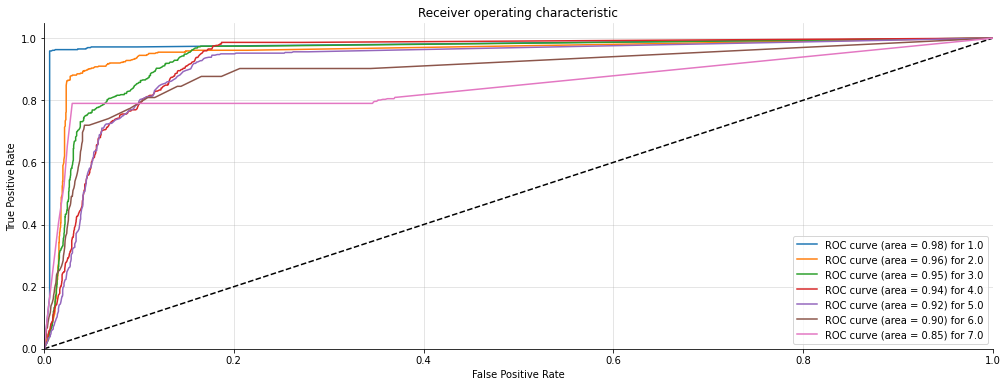

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.87      0.88      0.88       491
         3.0       0.84      0.82      0.83       487
         4.0       0.86      0.87      0.87       518
         5.0       0.91      0.92      0.92       487
         6.0       0.96      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  5 434  44   2   2   4   0]
 [  7  22 398  58   2   0   0]
 [  3  15  15 452  32   1   0]
 [  1   5  11   9 450  11   0]
 [  1   3   4   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9122023809523809
Precision Score : 0.9121443058639696
Recall Score : 0.9122023809523809
F1 Score : 0.91214057655905

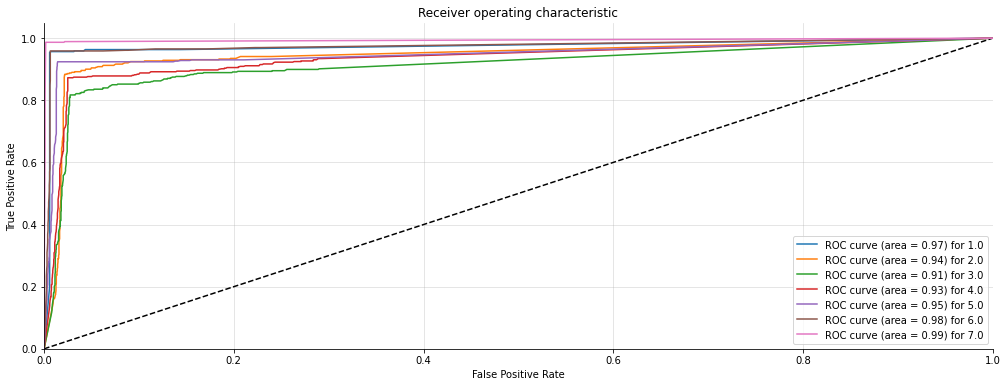

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.86      0.87      0.86       495
         3.0       0.82      0.79      0.81       490
         4.0       0.83      0.84      0.83       519
         5.0       0.89      0.91      0.90       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  5 432  48   2   3   4   1]
 [  7  27 386  69   0   1   0]
 [  3  17  17 435  47   0   0]
 [  1   8  10  15 436  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8994047619047619
Precision Score : 0.8991700730442526
Recall Score : 0.8994047619047619
F1 Score : 0.89

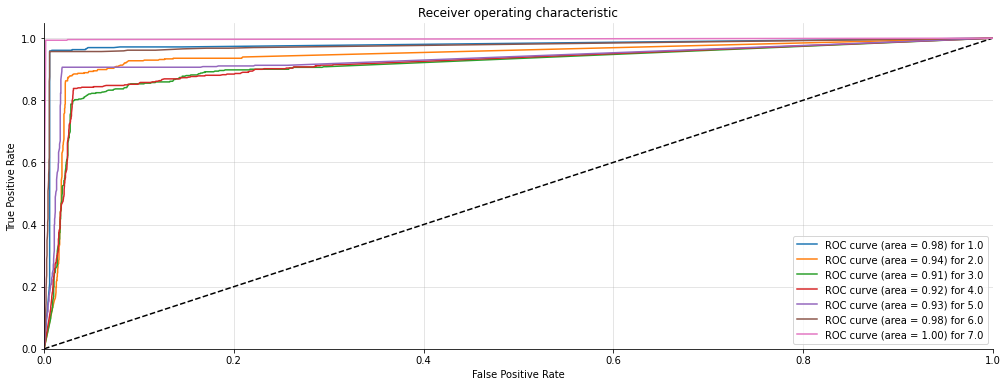

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.96      0.95      0.96       502
         3.0       0.94      0.94      0.94       474
         4.0       0.95      0.95      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  5 479  15   2   1   0   0]
 [  0  11 445  17   0   1   0]
 [  0   1  12 500  10   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9702380952380952
Precision Score : 0.9702129397073556
Recall Score : 0.9702380952380952
F1 Score : 0.9702147

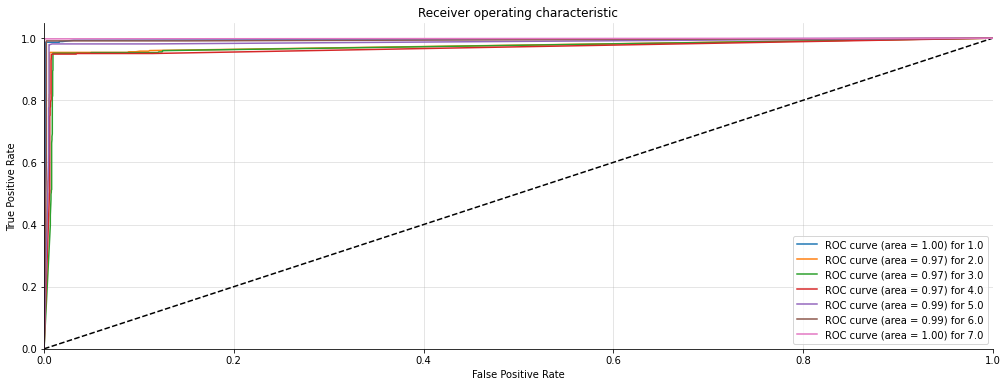

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0]
 [  0   0 478   0   0   0   0]
 [  0   0   0 523   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
(3360, 7) (3360, 7)


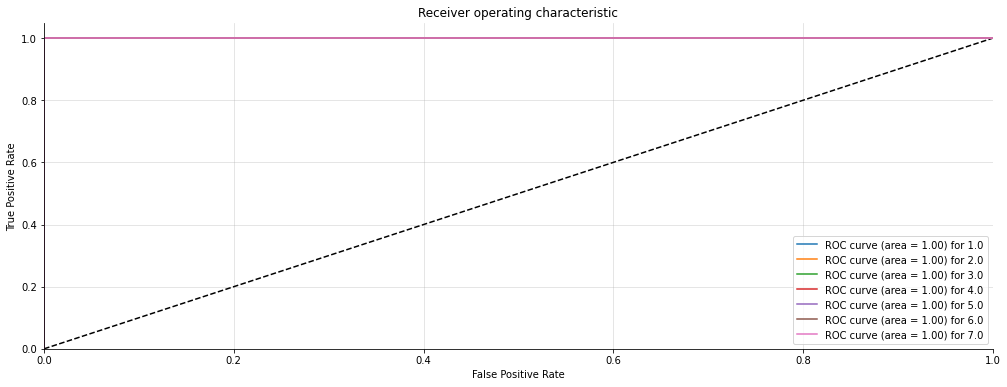

In [41]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def RFC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = RandomForestClassifier(n_estimators=100, max_depth=None,
     min_samples_split=2, random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  RFC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [42]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE {}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['RandomForestClassifier'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.8660342261904762
average Precision :0.8661709990690065
average Recall :0.8660342261904762
average F1 -score :0.8659723823749264
average RMSE 0.6023674885782007
average AUC score 0.921678217787119


# 4.7.3 Extra Trees Classifier

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.84      0.89      0.86       482
         3.0       0.77      0.74      0.75       510
         4.0       0.68      0.68      0.68       517
         5.0       0.64      0.66      0.65       467
         6.0       0.73      0.71      0.72       470
         7.0       0.82      0.81      0.82       452

    accuracy                           0.78      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.78      0.78      0.77      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  2 428  50   0   1   1   0]
 [  0  10 375 120   2   3   0]
 [  0   1  20 352 143   1   0]
 [  4   5  13  27 307 111   0]
 [  3  20   9  11  11 333  83]
 [ 10  27  20  10  12   5 368]]
Accuracy Score : 0.7752976190476191
Precision Score : 0.7750285373844749
Recall Score : 0.7752976190476191
F1 Score : 0.7749570

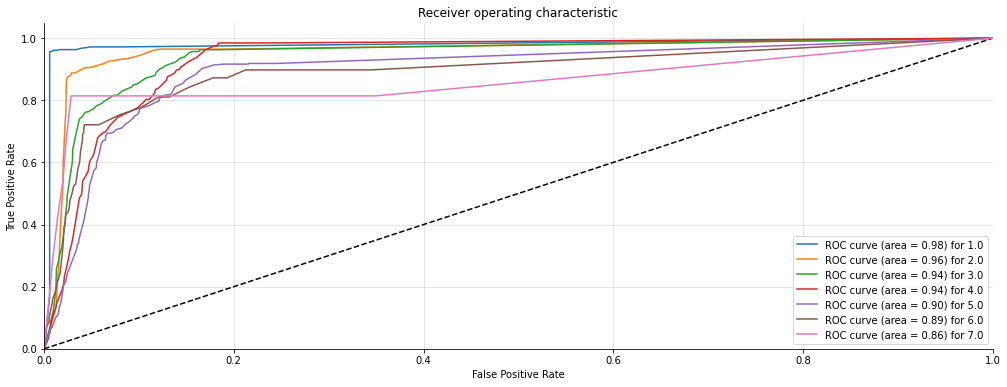

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.84      0.88      0.86       485
         3.0       0.77      0.75      0.76       501
         4.0       0.70      0.69      0.70       515
         5.0       0.71      0.74      0.72       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.81      3360
   macro avg       0.82      0.82      0.82      3360
weighted avg       0.81      0.81      0.81      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  2 428  51   0   1   3   0]
 [  0   9 376 114   2   0   0]
 [  0   2  29 356 126   2   0]
 [  3  13  16  18 340  70   0]
 [  5  19  13  14   6 384  43]
 [  9  19   5   4   5   2 408]]
Accuracy Score : 0.8136904761904762
Precision Score : 0.813908843576547
Recall Score : 0.8136904761904762
F1 Score : 0.81359006557159

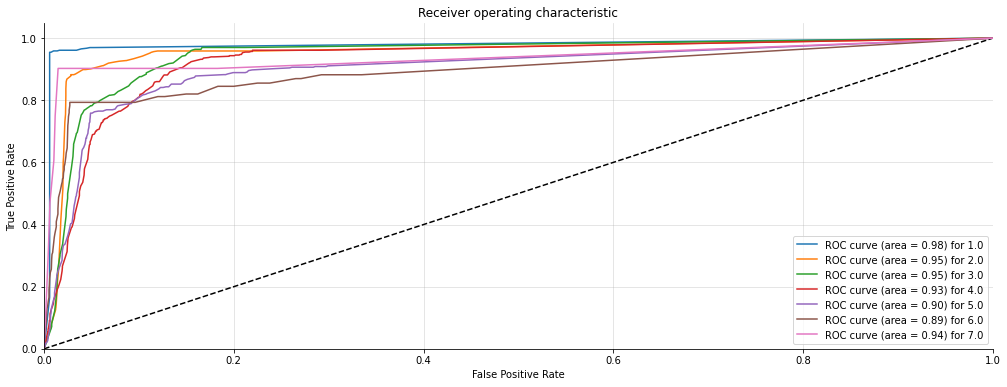

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.84      0.89      0.86       482
         3.0       0.76      0.74      0.75       506
         4.0       0.69      0.67      0.68       526
         5.0       0.65      0.68      0.66       458
         6.0       0.72      0.69      0.71       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.78      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.78      0.78      0.78      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  2 429  50   0   1   0   0]
 [  0   9 375 118   1   3   0]
 [  0   2  27 352 145   0   0]
 [  2   5   6  19 310 116   0]
 [  6  19  19  12  13 329  77]
 [  9  28  15  11   9   5 374]]
Accuracy Score : 0.7770833333333333
Precision Score : 0.77664743594845
Recall Score : 0.7770833333333333
F1 Score : 0.7766213120

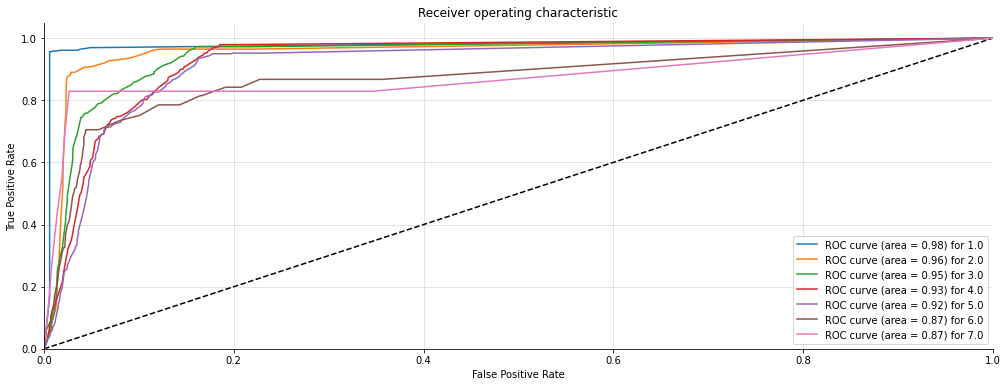

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.84      0.88      0.86       488
         3.0       0.76      0.75      0.75       506
         4.0       0.67      0.67      0.67       516
         5.0       0.65      0.68      0.66       456
         6.0       0.73      0.71      0.72       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  2 428  52   1   2   3   0]
 [  0   9 377 119   0   1   0]
 [  0   0  24 346 145   1   0]
 [  2   2   8  24 308 112   0]
 [  2  15  17   8  10 333  86]
 [ 13  35  20  16   9   4 365]]
Accuracy Score : 0.7735119047619048
Precision Score : 0.7735796232705643
Recall Score : 0.7735119047619048
F1 Score : 0.7734040926347

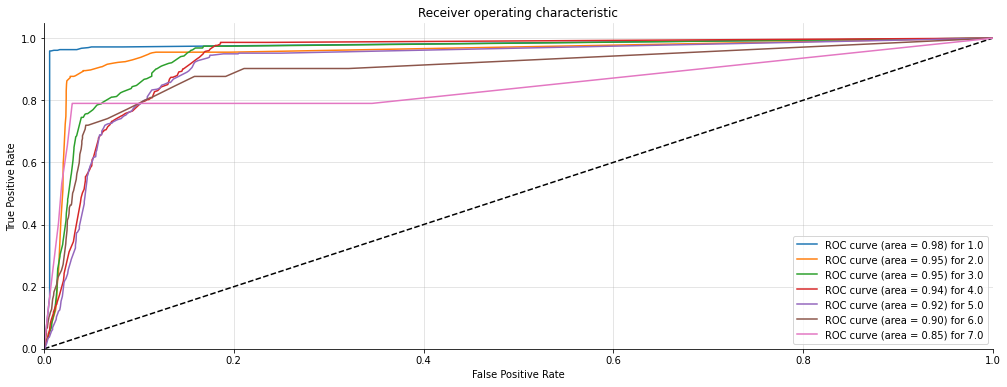

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.87      0.88      0.88       491
         3.0       0.83      0.82      0.82       487
         4.0       0.86      0.87      0.87       518
         5.0       0.92      0.92      0.92       487
         6.0       0.96      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  5 434  46   2   1   3   0]
 [  7  23 397  58   2   0   0]
 [  3  15  15 452  32   1   0]
 [  1   5  11   9 450  11   0]
 [  1   3   4   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9119047619047619
Precision Score : 0.9118831910801829
Recall Score : 0.9119047619047619
F1 Score : 0.91186398717164

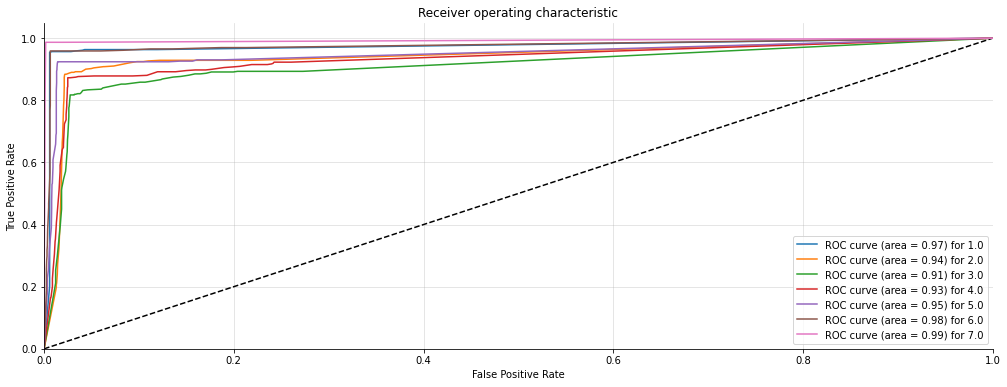

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.86      0.87      0.87       495
         3.0       0.82      0.79      0.81       490
         4.0       0.83      0.84      0.83       519
         5.0       0.89      0.91      0.90       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  5 433  49   2   2   4   0]
 [  7  27 386  69   0   1   0]
 [  3  17  17 435  47   0   0]
 [  1   8  10  15 436  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.899702380952381
Precision Score : 0.8995060229208637
Recall Score : 0.899702380952381
F1 Score : 0.8995

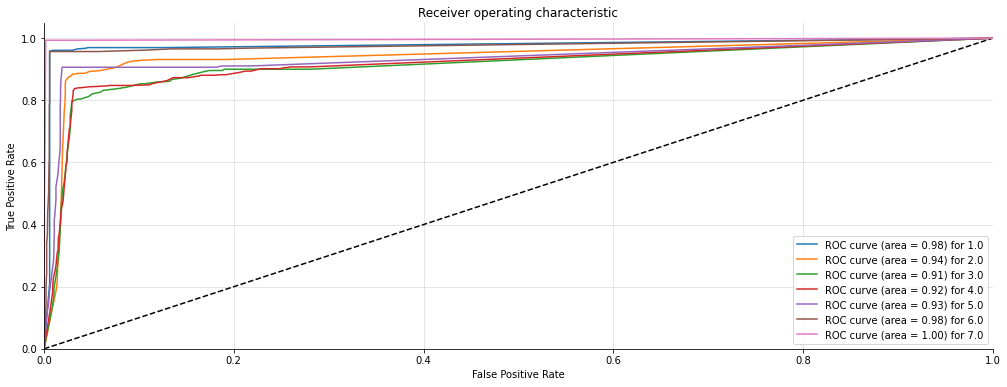

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.96      0.95      0.96       502
         3.0       0.94      0.95      0.95       474
         4.0       0.96      0.95      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  5 479  15   2   1   0   0]
 [  0  11 450  13   0   0   0]
 [  0   1  12 500  10   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9717261904761905
Precision Score : 0.9717262283839122
Recall Score : 0.9717261904761905
F1 Score : 0.9717136

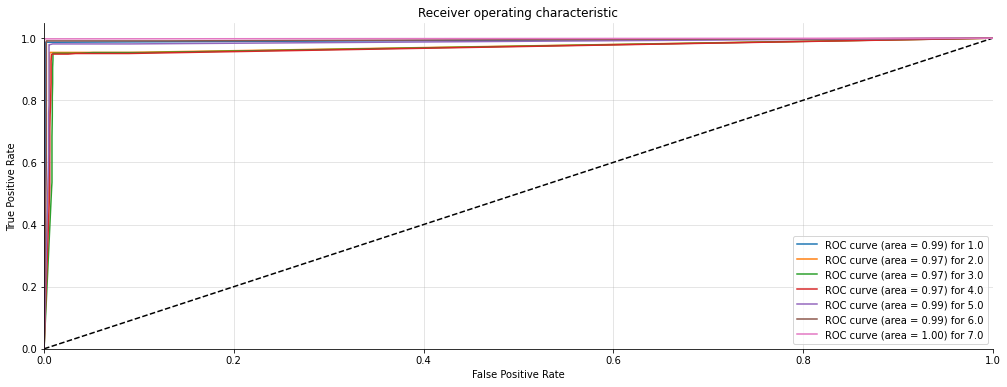

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0]
 [  0   0 478   0   0   0   0]
 [  0   0   0 523   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
(3360, 7) (3360, 7)


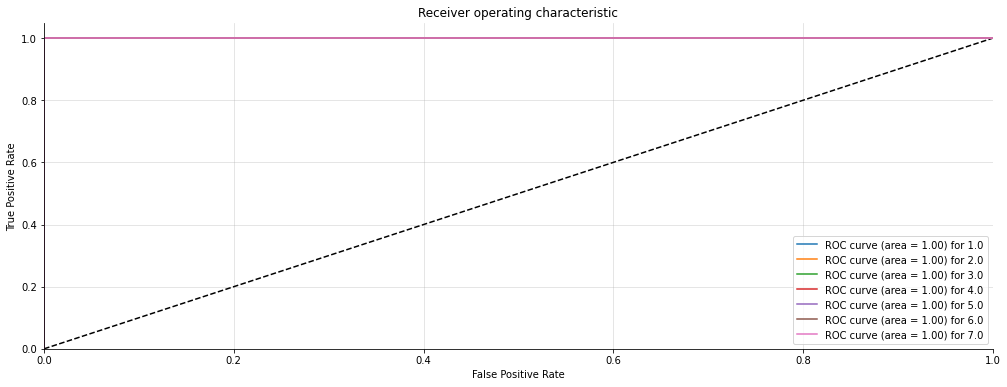

In [43]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def ETC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = ExtraTreesClassifier(n_estimators=100, max_depth=None,
     min_samples_split=2, random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  ETC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [44]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE {}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['ExtraTreesClassifier'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.8653645833333333
average Precision :0.8652849853206244
average Recall :0.8653645833333333
average F1 -score :0.8652083953704663
average RMSE 0.5960714608720428
average AUC score 0.9212798822165161


# 4.7.4 Adaboost 

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.60      0.66      0.63       462
         2.0       0.36      0.44      0.40       482
         3.0       0.33      0.25      0.29       510
         4.0       0.39      0.32      0.35       517
         5.0       0.25      0.30      0.27       467
         6.0       0.39      0.39      0.39       470
         7.0       0.72      0.69      0.70       452

    accuracy                           0.43      3360
   macro avg       0.43      0.43      0.43      3360
weighted avg       0.43      0.43      0.43      3360

Confusion Matrix: 
 [[304  61  31  18  29  13   6]
 [ 65 214  46  46  59  42  10]
 [ 57 114 127  91  49  68   4]
 [ 16  89  95 166  94  41  16]
 [ 24  51  58  81 139 107   7]
 [ 23  45  10  18 114 183  77]
 [ 20  17  13   9  72  11 310]]
Accuracy Score : 0.4294642857142857
Precision Score : 0.4311123313943624
Recall Score : 0.4294642857142857
F1 Score : 0.4277252

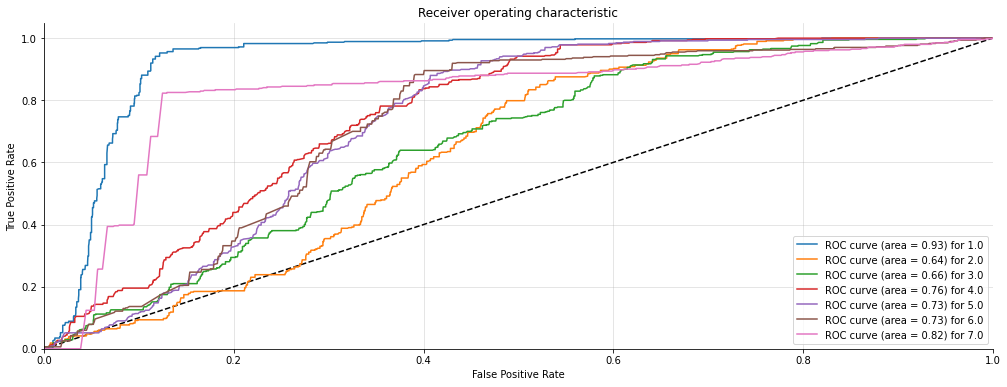

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.57      0.66      0.61       463
         2.0       0.38      0.40      0.39       485
         3.0       0.28      0.34      0.30       501
         4.0       0.37      0.38      0.37       515
         5.0       0.35      0.26      0.30       460
         6.0       0.51      0.44      0.47       484
         7.0       0.84      0.75      0.79       452

    accuracy                           0.46      3360
   macro avg       0.47      0.46      0.46      3360
weighted avg       0.47      0.46      0.46      3360

Confusion Matrix: 
 [[307  55  41  30  12  14   4]
 [ 67 196  80  42  50  40  10]
 [ 55  86 170  94  49  41   6]
 [ 28  71 107 194  82  30   3]
 [ 47  38  71 106 121  75   2]
 [ 21  58  67  56  31 213  38]
 [ 12  12  79   5   2   4 338]]
Accuracy Score : 0.45803571428571427
Precision Score : 0.46595350130051094
Recall Score : 0.45803571428571427
F1 Score : 0.4594056711

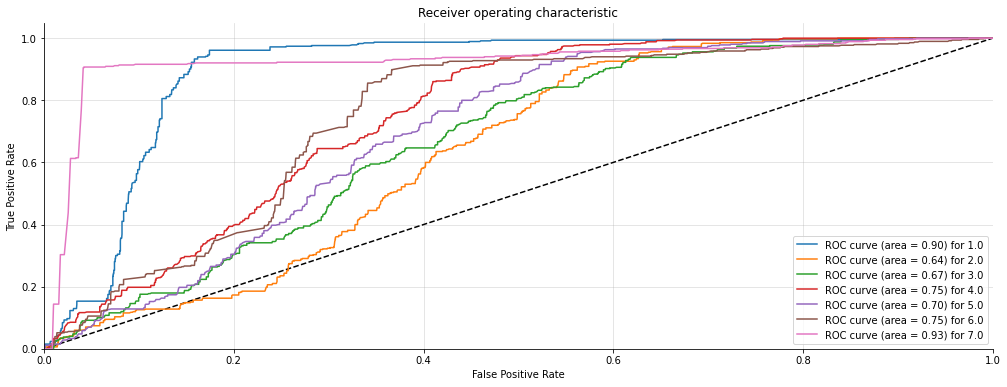

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.61      0.68      0.64       462
         2.0       0.35      0.47      0.40       482
         3.0       0.27      0.27      0.27       506
         4.0       0.37      0.28      0.32       526
         5.0       0.27      0.30      0.28       458
         6.0       0.45      0.37      0.41       475
         7.0       0.63      0.56      0.59       451

    accuracy                           0.41      3360
   macro avg       0.42      0.42      0.42      3360
weighted avg       0.42      0.41      0.41      3360

Confusion Matrix: 
 [[312  63  38  21   8   8  12]
 [ 50 225  61  38  60  30  18]
 [ 56 110 137  82  46  46  29]
 [ 24  98  92 145 108  45  14]
 [ 36  61  65  71 137  81   7]
 [ 18  58  40  27  87 178  67]
 [ 18  24  71   9  68   9 252]]
Accuracy Score : 0.4125
Precision Score : 0.4171599204027372
Recall Score : 0.4125
F1 Score : 0.41147813820292145
(3360, 7) (336

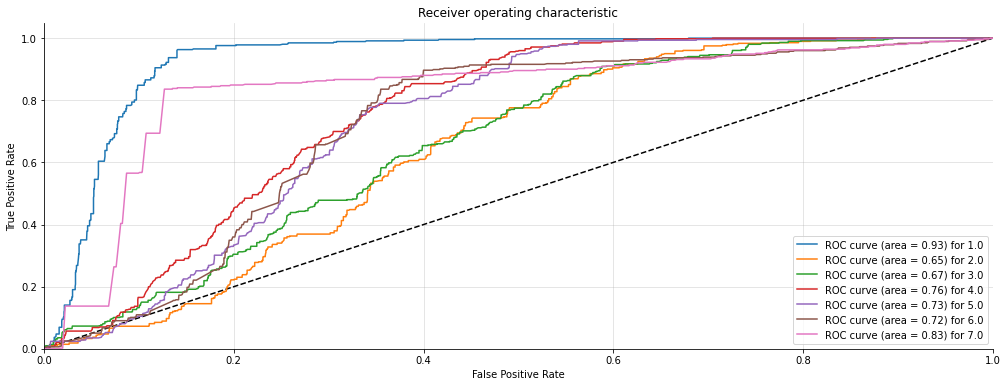

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.58      0.64      0.61       461
         2.0       0.40      0.45      0.42       488
         3.0       0.36      0.29      0.32       506
         4.0       0.35      0.30      0.32       516
         5.0       0.26      0.26      0.26       456
         6.0       0.41      0.46      0.43       471
         7.0       0.67      0.66      0.67       462

    accuracy                           0.43      3360
   macro avg       0.43      0.44      0.43      3360
weighted avg       0.43      0.43      0.43      3360

Confusion Matrix: 
 [[295  71  31  18  16  30   0]
 [ 54 222  56  39  48  53  16]
 [ 48  98 145  88  47  61  19]
 [ 41  71  72 154  86  71  21]
 [ 37  38  54 102 119  97   9]
 [ 20  31  32  21  65 218  84]
 [ 17  28  13  19  72   7 306]]
Accuracy Score : 0.4342261904761905
Precision Score : 0.4295746903689392
Recall Score : 0.4342261904761905
F1 Score : 0.4301895796816

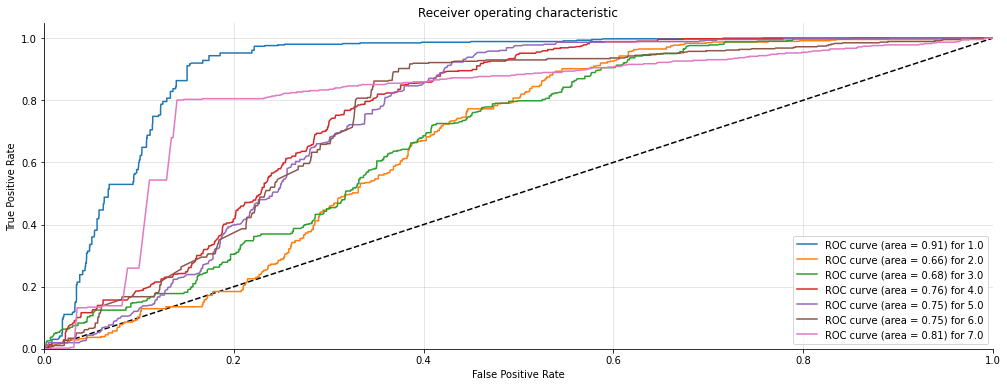

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.25      0.43      0.31       463
         2.0       0.23      0.14      0.17       491
         3.0       0.24      0.18      0.21       487
         4.0       0.31      0.18      0.23       518
         5.0       0.23      0.25      0.24       487
         6.0       0.34      0.41      0.37       462
         7.0       0.92      0.99      0.95       452

    accuracy                           0.36      3360
   macro avg       0.36      0.37      0.35      3360
weighted avg       0.35      0.36      0.35      3360

Confusion Matrix: 
 [[199  47  28  44  78  67   0]
 [130  67  57  53  91  85   8]
 [130  46  88  50  97  66  10]
 [113  53  54  95  94 103   6]
 [162  60  36  51 123  47   8]
 [ 73  16 104  12  63 189   5]
 [  3   0   1   1   0   1 446]]
Accuracy Score : 0.3592261904761905
Precision Score : 0.35369665212011403
Recall Score : 0.3592261904761905
F1 Score : 0.3473797939195

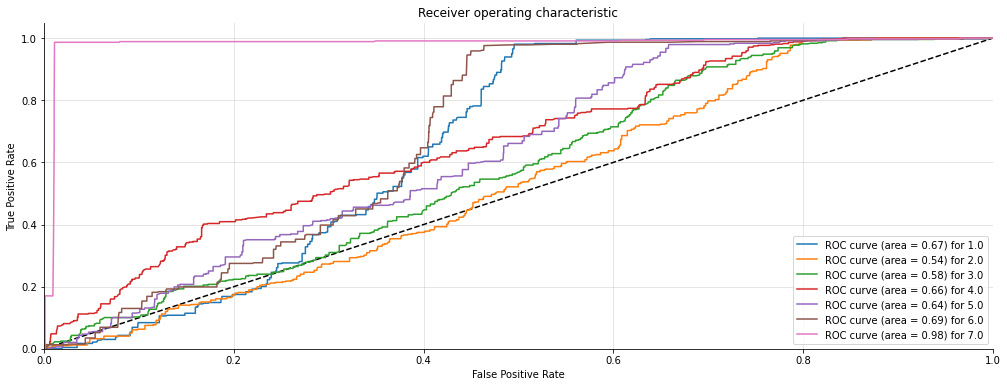

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.23      0.35      0.28       461
         2.0       0.16      0.08      0.11       495
         3.0       0.21      0.24      0.23       490
         4.0       0.29      0.24      0.26       519
         5.0       0.27      0.37      0.31       481
         6.0       0.34      0.28      0.31       465
         7.0       0.96      0.82      0.89       449

    accuracy                           0.33      3360
   macro avg       0.35      0.34      0.34      3360
weighted avg       0.35      0.33      0.33      3360

Confusion Matrix: 
 [[163  45  48  68  96  41   0]
 [138  39  82  60 105  70   1]
 [119  48 118  58  93  48   6]
 [ 86  49  96 125 116  44   3]
 [ 70  36  61  84 179  51   0]
 [132  20  69  33  74 132   5]
 [  0   0  79   0   1   0 369]]
Accuracy Score : 0.33482142857142855
Precision Score : 0.34638916429723104
Recall Score : 0.33482142857142855
F1 Score : 0

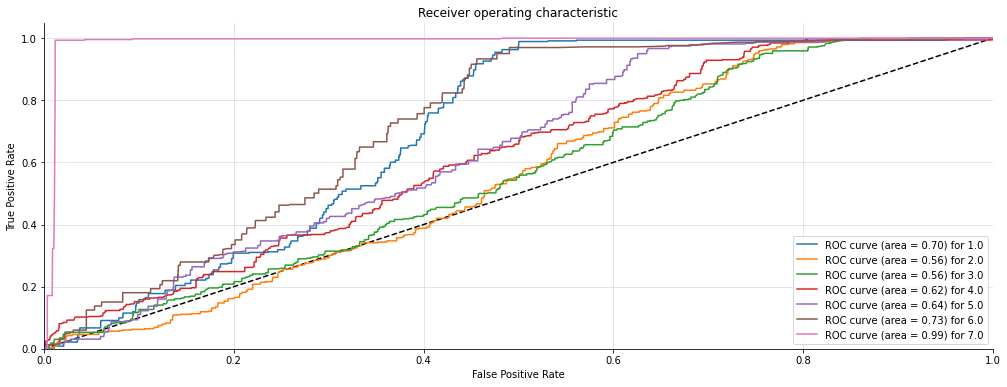

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.18      0.43      0.26       460
         2.0       0.26      0.18      0.21       502
         3.0       0.17      0.18      0.17       474
         4.0       0.31      0.13      0.18       527
         5.0       0.15      0.18      0.16       486
         6.0       0.25      0.15      0.19       459
         7.0       0.91      0.65      0.76       452

    accuracy                           0.27      3360
   macro avg       0.32      0.27      0.28      3360
weighted avg       0.31      0.27      0.27      3360

Confusion Matrix: 
 [[199  61  72  42  81   1   4]
 [175  90  70  25 102  38   2]
 [164  47  85  41  94  39   4]
 [166  44  84  68 118  47   0]
 [162  60 119  26  86  23  10]
 [128  47  85  20  97  71  11]
 [ 86   0   0   0   1  69 296]]
Accuracy Score : 0.2663690476190476
Precision Score : 0.31201306707624443
Recall Score : 0.2663690476190476
F1 Score : 0.271270

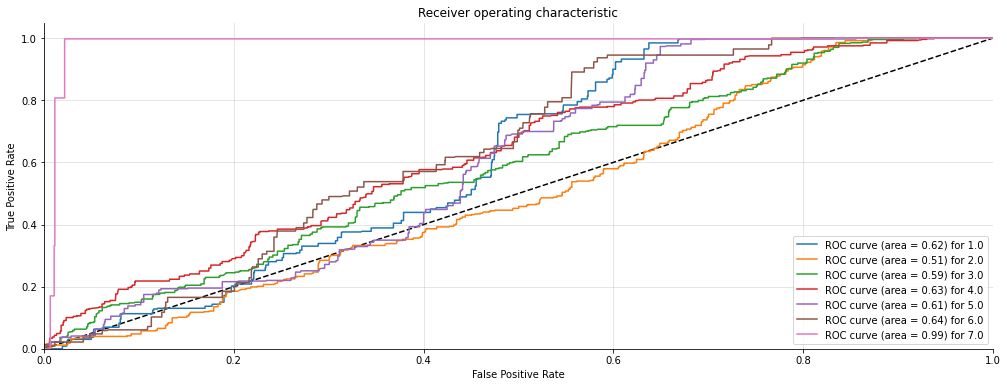

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.32      0.17      0.22       459
         2.0       0.29      0.21      0.25       496
         3.0       0.18      0.12      0.14       478
         4.0       0.14      0.14      0.14       523
         5.0       0.15      0.12      0.13       491
         6.0       0.19      0.52      0.27       462
         7.0       0.98      0.64      0.77       451

    accuracy                           0.27      3360
   macro avg       0.32      0.27      0.28      3360
weighted avg       0.31      0.27      0.27      3360

Confusion Matrix: 
 [[ 77  71  30  62  49 170   0]
 [ 34 106  63  33  78 182   0]
 [ 33  38  56  78  64 206   3]
 [ 52  38  51  71  64 243   4]
 [ 23  59  50  65  57 237   0]
 [ 24  50  56  35  58 239   0]
 [  0   0   0 163   0   0 288]]
Accuracy Score : 0.26607142857142857
Precision Score : 0.31363253968737376
Recall Score : 0.26607142857142857
F1 Score : 0.26900642

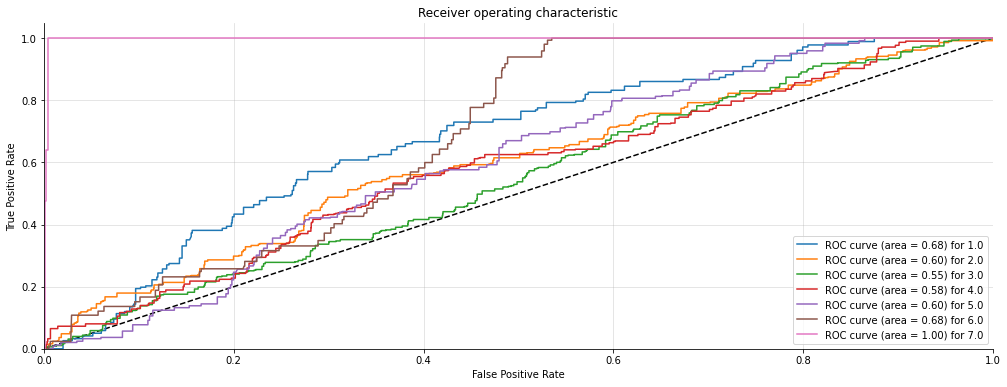

In [45]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def ADB(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = AdaBoostClassifier(n_estimators=500)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  ADB(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [46]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE {}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['AdaBoost'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.3700892857142857
average Precision :0.38369148333093916
average Recall :0.3700892857142857
average F1 -score :0.3687842141417669
average RMSE 2.0486094261077947
average AUC score 0.6323926087375132


# 4.7.5 Gradient boosting 

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.49      0.81      0.61       462
         2.0       0.33      0.23      0.28       482
         3.0       0.32      0.26      0.29       510
         4.0       0.30      0.26      0.28       517
         5.0       0.25      0.25      0.25       467
         6.0       0.24      0.24      0.24       470
         7.0       0.56      0.56      0.56       452

    accuracy                           0.37      3360
   macro avg       0.35      0.37      0.36      3360
weighted avg       0.35      0.37      0.35      3360

Confusion Matrix: 
 [[372  28  15  17  14   8   8]
 [ 96 113  89  64  41  62  17]
 [ 83  46 133  81  65  69  33]
 [ 83  44  62 134 104  47  43]
 [ 65  64  67  87 115  50  19]
 [ 37  38  31  62 106 115  81]
 [ 24   6  21   9  11 129 252]]
Accuracy Score : 0.3672619047619048
Precision Score : 0.3522300439833334
Recall Score : 0.3672619047619048
F1 Score : 0.3525971

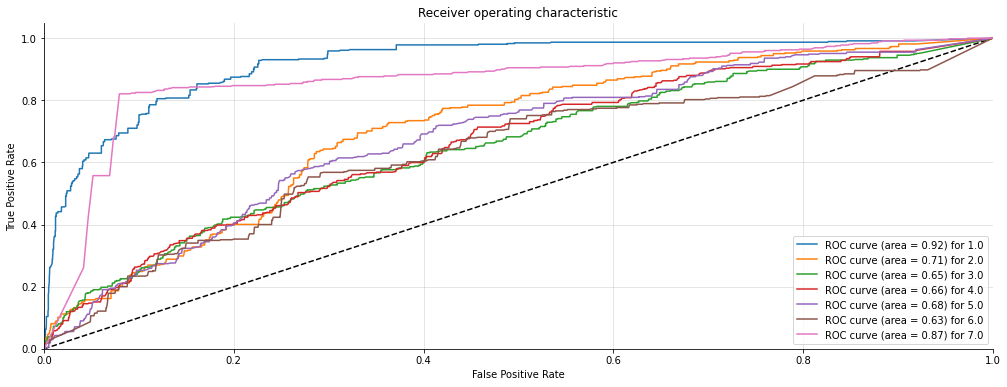

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.47      0.73      0.57       463
         2.0       0.25      0.33      0.29       485
         3.0       0.32      0.13      0.18       501
         4.0       0.31      0.18      0.23       515
         5.0       0.25      0.23      0.24       460
         6.0       0.29      0.25      0.27       484
         7.0       0.53      0.76      0.62       452

    accuracy                           0.37      3360
   macro avg       0.35      0.37      0.34      3360
weighted avg       0.34      0.37      0.34      3360

Confusion Matrix: 
 [[339  42   7  18  17  16  24]
 [ 97 162  33  51  49  30  63]
 [ 75 127  65  64  71  52  47]
 [ 64 113  30  94 107  53  54]
 [ 69  89  39  40 108  77  38]
 [ 61  92  24  28  80 120  79]
 [ 17  11   4   4   2  70 344]]
Accuracy Score : 0.36666666666666664
Precision Score : 0.344359296606199
Recall Score : 0.36666666666666664
F1 Score : 0.339001233424

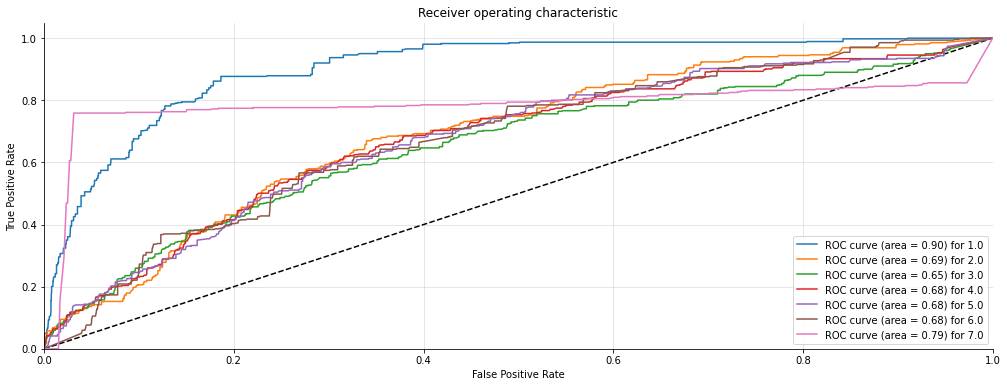

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.50      0.82      0.62       462
         2.0       0.25      0.27      0.26       482
         3.0       0.34      0.24      0.28       506
         4.0       0.28      0.23      0.25       526
         5.0       0.25      0.29      0.27       458
         6.0       0.25      0.15      0.19       475
         7.0       0.57      0.57      0.57       451

    accuracy                           0.36      3360
   macro avg       0.35      0.37      0.35      3360
weighted avg       0.34      0.36      0.34      3360

Confusion Matrix: 
 [[381  32  13  17   9   2   8]
 [ 93 129  85  71  59  25  20]
 [ 74  96 121  66  99  19  31]
 [ 87  76  58 123 128  14  40]
 [ 57  85  40  90 135  31  20]
 [ 52  80  27  67 100  73  76]
 [ 23  18  13   8  10 123 256]]
Accuracy Score : 0.3625
Precision Score : 0.3449969983594502
Recall Score : 0.3625
F1 Score : 0.34450466500074306
(3360, 7) (336

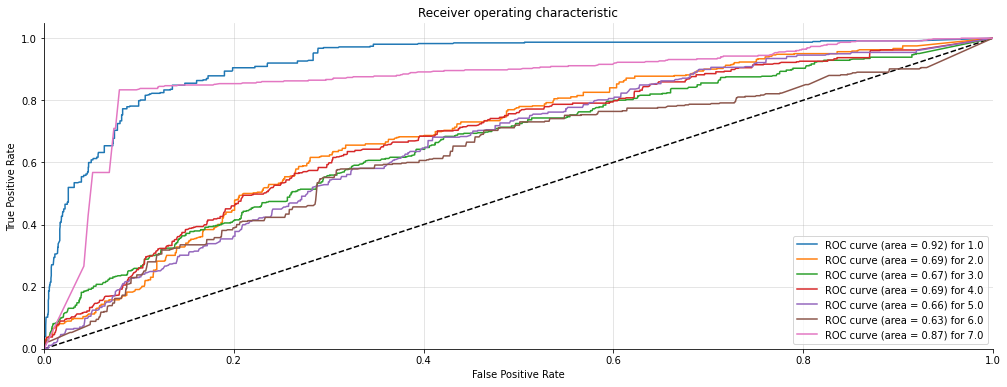

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.57      0.85      0.68       461
         2.0       0.47      0.44      0.46       488
         3.0       0.55      0.38      0.45       506
         4.0       0.49      0.40      0.44       516
         5.0       0.42      0.41      0.42       456
         6.0       0.58      0.66      0.62       471
         7.0       0.78      0.79      0.79       462

    accuracy                           0.56      3360
   macro avg       0.55      0.56      0.55      3360
weighted avg       0.55      0.56      0.55      3360

Confusion Matrix: 
 [[393  41   4   1   8  14   0]
 [ 80 217  50  39  59  35   8]
 [ 60  82 193  90  46  28   7]
 [ 62  54  50 204 119  27   0]
 [ 51  20  23  65 187 110   0]
 [ 28  14  14   8  11 310  86]
 [ 21  29  16  13  10   6 367]]
Accuracy Score : 0.5568452380952381
Precision Score : 0.5516777840524559
Recall Score : 0.5568452380952381
F1 Score : 0.5468340491162

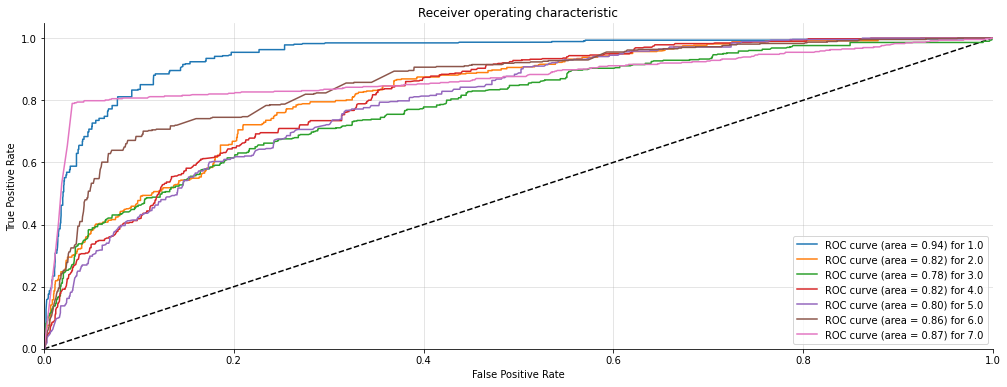

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.49      0.68      0.57       463
         2.0       0.47      0.47      0.47       491
         3.0       0.35      0.26      0.30       487
         4.0       0.44      0.35      0.39       518
         5.0       0.28      0.25      0.26       487
         6.0       0.39      0.40      0.40       462
         7.0       0.83      0.99      0.90       452

    accuracy                           0.48      3360
   macro avg       0.46      0.49      0.47      3360
weighted avg       0.46      0.48      0.47      3360

Confusion Matrix: 
 [[316  54  12  27  24  22   8]
 [ 72 230  45  31  60  38  15]
 [ 71  85 129  64  66  61  11]
 [ 68  59  67 182  61  65  16]
 [ 65  36  84  56 122 101  23]
 [ 46  20  36  58 101 185  16]
 [  2   2   0   0   1   1 446]]
Accuracy Score : 0.4791666666666667
Precision Score : 0.4610203891544742
Recall Score : 0.4791666666666667
F1 Score : 0.46553904544874

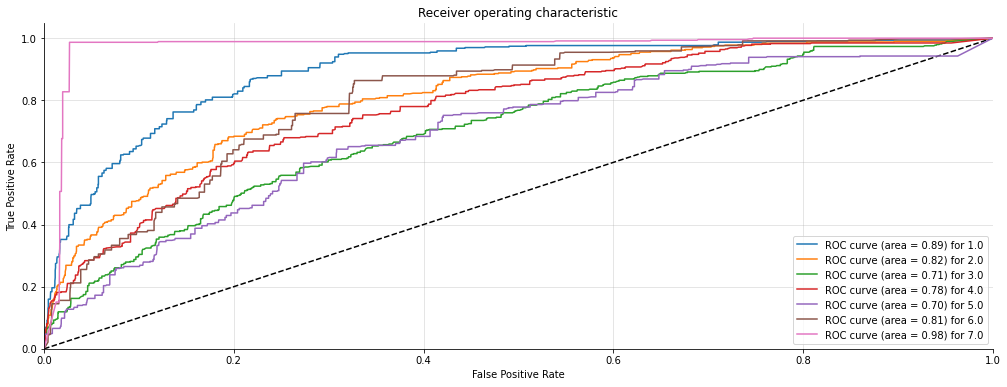

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.54      0.75      0.63       461
         2.0       0.51      0.47      0.49       495
         3.0       0.37      0.36      0.36       490
         4.0       0.47      0.38      0.42       519
         5.0       0.34      0.29      0.31       481
         6.0       0.46      0.50      0.48       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.53      3360
   macro avg       0.52      0.53      0.53      3360
weighted avg       0.52      0.53      0.52      3360

Confusion Matrix: 
 [[345  50   7  11  23  25   0]
 [ 76 232  72  35  47  32   1]
 [ 58  82 175  65  56  54   0]
 [ 53  47  82 198  74  65   0]
 [ 70  25  81  72 140  93   0]
 [ 36  19  53  44  76 232   5]
 [  0   0   0   0   1   2 446]]
Accuracy Score : 0.5261904761904762
Precision Score : 0.5193220186109281
Recall Score : 0.5261904761904762
F1 Score : 0.51

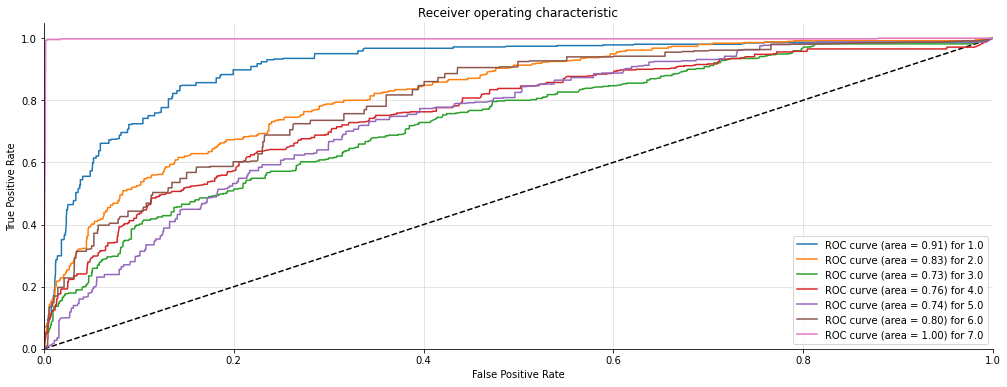

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.58      0.85      0.69       460
         2.0       0.33      0.36      0.34       502
         3.0       0.33      0.27      0.30       474
         4.0       0.46      0.40      0.43       527
         5.0       0.39      0.36      0.38       486
         6.0       0.50      0.42      0.46       459
         7.0       0.98      1.00      0.99       452

    accuracy                           0.52      3360
   macro avg       0.51      0.52      0.51      3360
weighted avg       0.51      0.52      0.51      3360

Confusion Matrix: 
 [[392  27   2  10  18  11   0]
 [102 181  79  50  70  20   0]
 [ 48 109 130  57  74  51   5]
 [ 47  69  87 210  62  47   5]
 [ 45  88  38  77 176  62   0]
 [ 36  76  57  48  50 192   0]
 [  1   0   0   0   0   0 451]]
Accuracy Score : 0.5154761904761904
Precision Score : 0.5053423633011356
Recall Score : 0.5154761904761904
F1 Score : 0.5055049

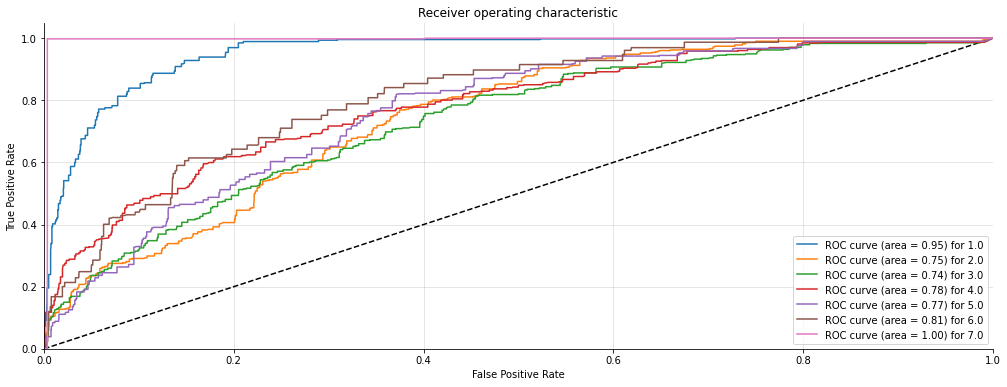

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.56      0.82      0.66       459
         2.0       0.55      0.54      0.55       496
         3.0       0.36      0.31      0.34       478
         4.0       0.51      0.42      0.46       523
         5.0       0.42      0.43      0.42       491
         6.0       0.55      0.47      0.50       462
         7.0       1.00      1.00      1.00       451

    accuracy                           0.56      3360
   macro avg       0.56      0.57      0.56      3360
weighted avg       0.56      0.56      0.56      3360

Confusion Matrix: 
 [[376  43  14   3  17   6   0]
 [ 70 270  54  29  62  11   0]
 [ 57  79 150  53  87  52   0]
 [ 61  52  73 220  66  51   0]
 [ 54  40  56  73 211  57   0]
 [ 54   9  68  54  62 215   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.5633928571428571
Precision Score : 0.5586671011077768
Recall Score : 0.5633928571428571
F1 Score : 0.55631252470

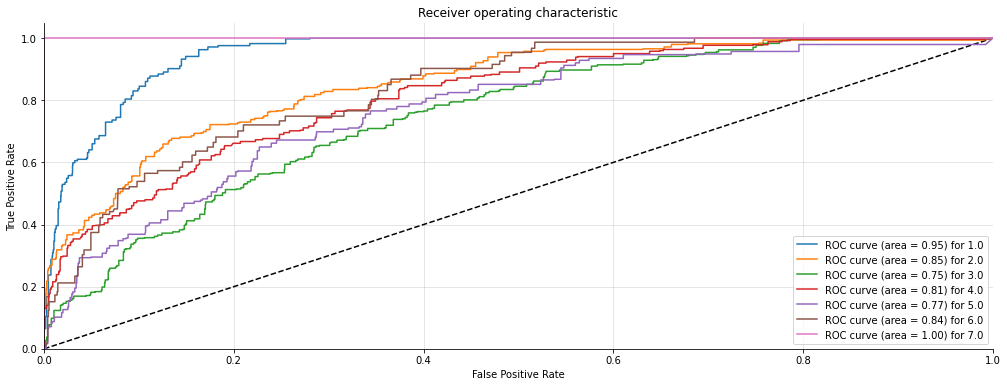

In [47]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def GBC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  GBC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [48]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE {}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['GradientBoost'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.4671875
average Precision :0.4547019993969692
average Recall :0.4671875
average F1 -score :0.45370304069336254
average RMSE 1.7638511391550393
average AUC score 0.6890758651424427


# 4.7.6 Bagging classfier

In [49]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.94      0.96      0.95       462
         2.0       0.82      0.88      0.85       482
         3.0       0.76      0.72      0.74       510
         4.0       0.65      0.65      0.65       517
         5.0       0.62      0.62      0.62       467
         6.0       0.73      0.70      0.72       470
         7.0       0.82      0.81      0.82       452

    accuracy                           0.76      3360
   macro avg       0.76      0.76      0.76      3360
weighted avg       0.76      0.76      0.76      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  5 425  46   0   5   1   0]
 [  4  17 366 114   6   3   0]
 [  1   5  30 338 142   1   0]
 [  4   5  12  45 290 111   0]
 [  3  19  10  10  16 329  83]
 [ 11  27  19  10  12   5 368]]
Accuracy Score : 0.7613095238095238
Precision Score : 0.7602306206166912
Recall Score : 0.7613095238095238
F1 Score : 0.7604704

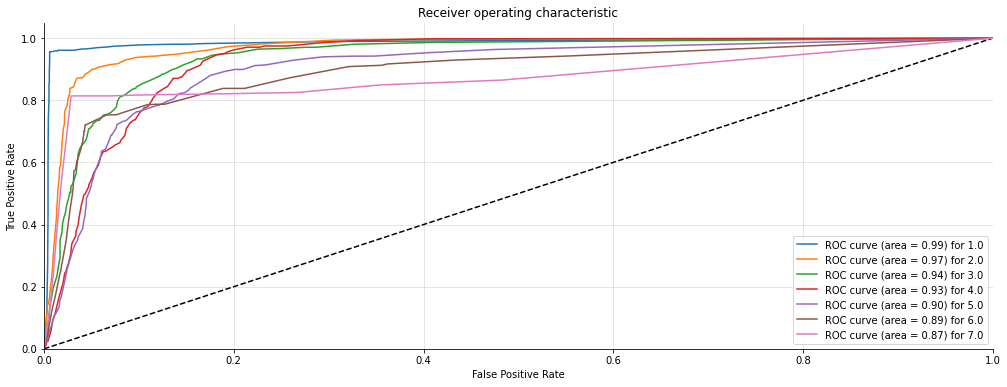

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.83      0.87      0.85       485
         3.0       0.74      0.75      0.75       501
         4.0       0.70      0.65      0.68       515
         5.0       0.71      0.75      0.73       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.81      3360
   macro avg       0.81      0.81      0.81      3360
weighted avg       0.81      0.81      0.81      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  3 423  52   0   3   4   0]
 [  0  10 378 111   2   0   0]
 [  0   5  44 337 127   2   0]
 [  3  12  16  15 344  70   0]
 [  5  18  14  14   6 384  43]
 [  9  19   6   3   5   2 408]]
Accuracy Score : 0.8083333333333333
Precision Score : 0.8082600128543691
Recall Score : 0.8083333333333333
F1 Score : 0.8079599405496

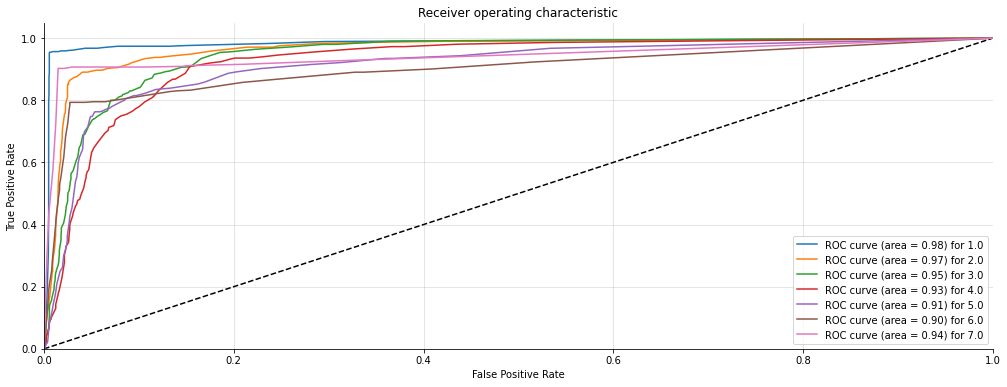

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.94      0.96      0.95       462
         2.0       0.82      0.88      0.85       482
         3.0       0.75      0.69      0.72       506
         4.0       0.67      0.68      0.67       526
         5.0       0.63      0.65      0.64       458
         6.0       0.72      0.67      0.70       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.76      3360
   macro avg       0.76      0.76      0.76      3360
weighted avg       0.76      0.76      0.76      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  3 423  51   0   4   1   0]
 [  5  25 349 119   1   5   2]
 [  0   2  28 358 138   0   0]
 [  2   4   7  37 296 112   0]
 [  6  18  20  12  22 320  77]
 [ 10  27  13  12  10   5 374]]
Accuracy Score : 0.7625
Precision Score : 0.7618480367547611
Recall Score : 0.7625
F1 Score : 0.7617034611069581
Accuracy: 0.755

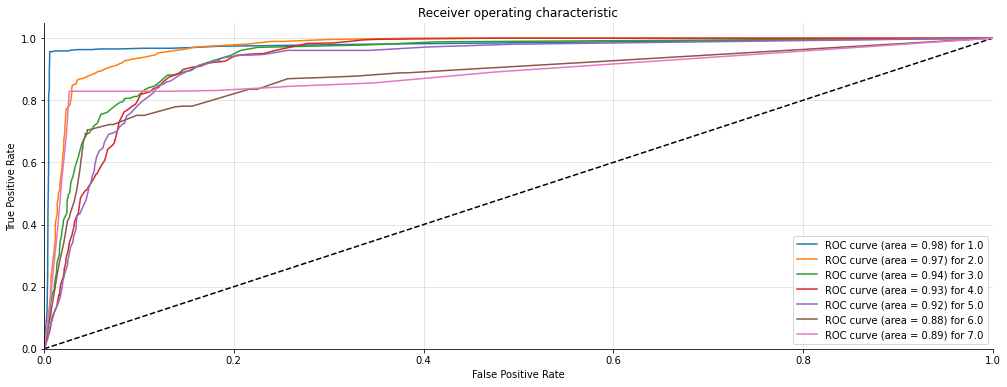

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96       461
         2.0       0.83      0.86      0.84       488
         3.0       0.74      0.73      0.73       506
         4.0       0.67      0.64      0.65       516
         5.0       0.64      0.68      0.66       456
         6.0       0.72      0.71      0.72       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.76      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.76      0.76      0.76      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  4 421  53   2   5   3   0]
 [  0  16 369 114   6   1   0]
 [  0   3  32 331 143   7   0]
 [  2   2   7  24 308 113   0]
 [  2  15  17   8   9 334  86]
 [ 13  34  21  16   9   4 365]]
Accuracy Score : 0.7648809523809523
Precision Score : 0.7646302493773731
Recall Score : 0.7648809523809523
F1 Score : 0.7645625799138

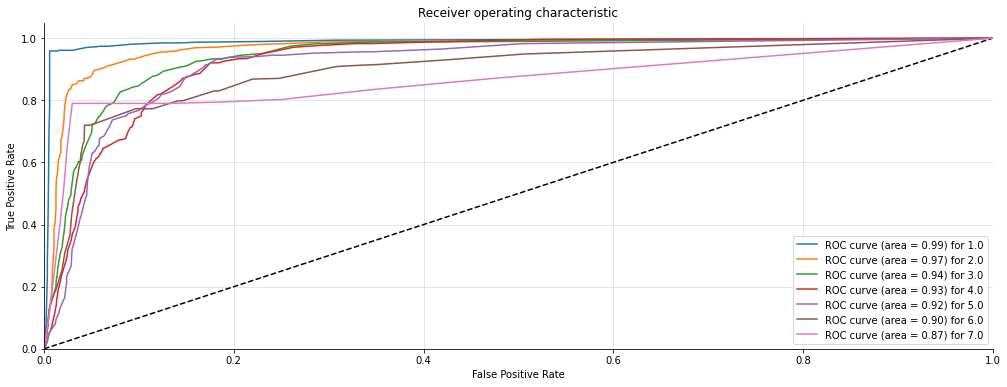

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.95      0.95      0.95       463
         2.0       0.86      0.87      0.87       491
         3.0       0.84      0.79      0.81       487
         4.0       0.86      0.87      0.86       518
         5.0       0.91      0.92      0.91       487
         6.0       0.95      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.90      0.91      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  8 427  43   5   4   4   0]
 [ 11  28 383  60   3   2   0]
 [  4  15  14 450  34   1   0]
 [  1   5  11   9 450  11   0]
 [  1   3   4   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9050595238095238
Precision Score : 0.9045813111819212
Recall Score : 0.9050595238095238
F1 Score : 0.90468096695152

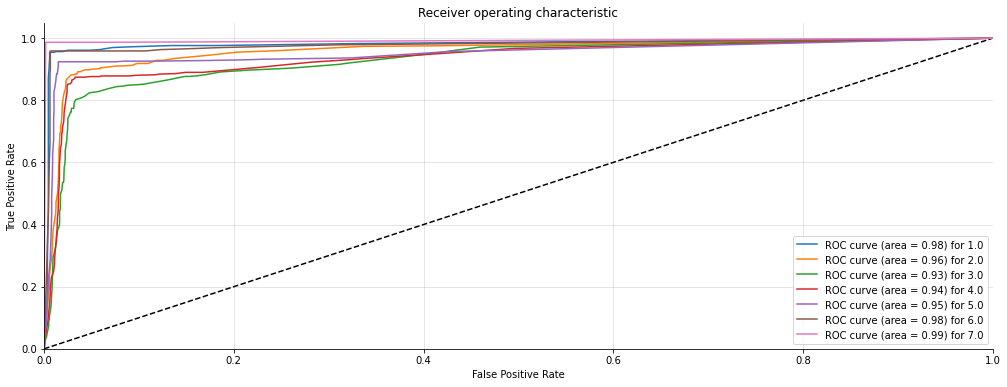

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.93      0.96      0.95       461
         2.0       0.83      0.85      0.84       495
         3.0       0.81      0.76      0.78       490
         4.0       0.83      0.81      0.82       519
         5.0       0.88      0.91      0.89       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.89      3360
   macro avg       0.89      0.89      0.89      3360
weighted avg       0.89      0.89      0.89      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [ 10 422  49   3   6   5   0]
 [ 13  34 372  67   1   3   0]
 [  7  22  22 420  48   0   0]
 [  1   9  10  14 436  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.887797619047619
Precision Score : 0.8868829793139038
Recall Score : 0.887797619047619
F1 Score : 0.8871

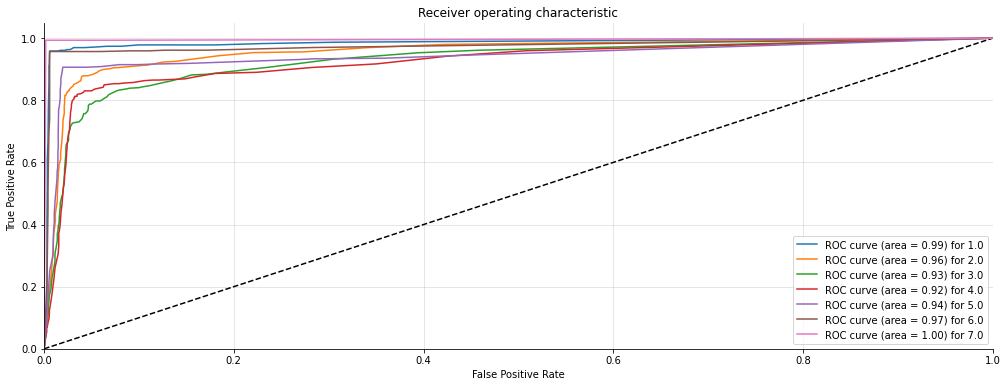

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.97      0.99      0.98       460
         2.0       0.97      0.94      0.95       502
         3.0       0.94      0.93      0.94       474
         4.0       0.96      0.94      0.95       527
         5.0       0.96      0.98      0.97       486
         6.0       0.97      0.99      0.98       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  6 470  17   2   3   4   0]
 [  4  10 443  13   1   3   0]
 [  3   1  12 495  12   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9654761904761905
Precision Score : 0.9654316919238862
Recall Score : 0.9654761904761905
F1 Score : 0.9653717

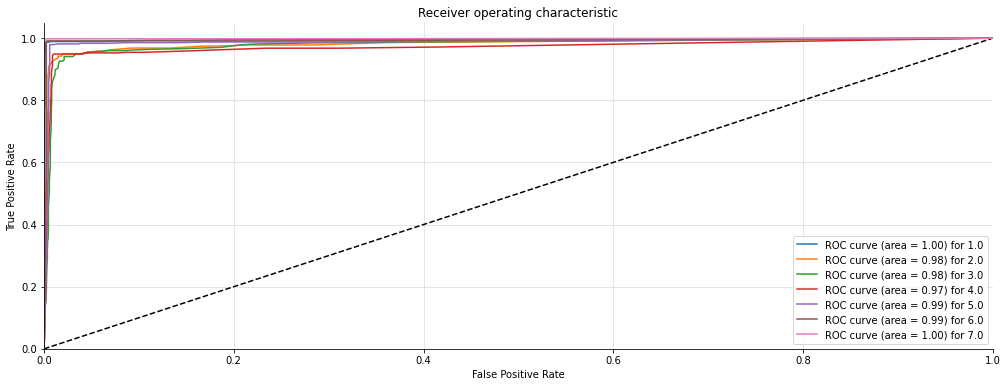

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.98      1.00      0.99       459
         2.0       1.00      0.98      0.99       496
         3.0       1.00      0.99      0.99       478
         4.0       1.00      0.99      1.00       523
         5.0       0.98      1.00      0.99       491
         6.0       0.99      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           0.99      3360
   macro avg       0.99      0.99      0.99      3360
weighted avg       0.99      0.99      0.99      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  6 484   0   0   6   0   0]
 [  4   0 471   0   0   3   0]
 [  0   0   1 520   2   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.993452380952381
Precision Score : 0.9935559878284326
Recall Score : 0.993452380952381
F1 Score : 0.9934488124668

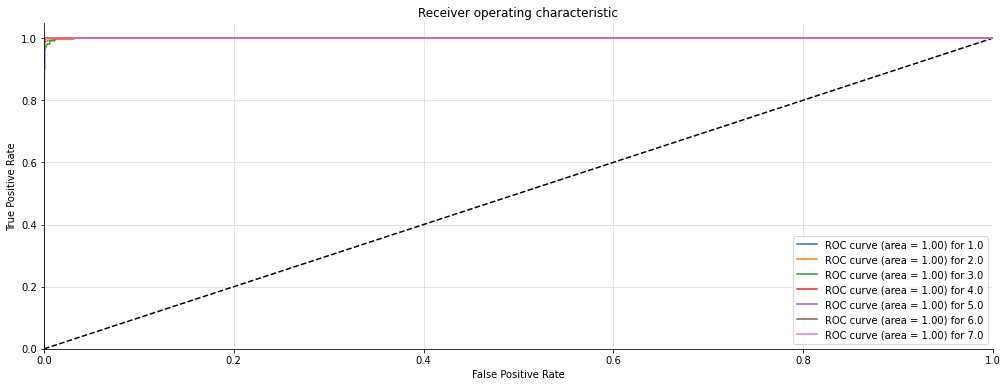

In [50]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def BAG(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    # report performance
    print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  BAG(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [51]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE {}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['BaggingClassifier'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.8561011904761904
average Precision :0.8556776112314173
average Recall :0.8561011904761904
average F1 -score :0.855665771355016
average RMSE 0.6495973493232051
average AUC score 0.9158732581314596


# Model Result Metrics display

In [52]:
metric_df

metric       XGB       SVM  OrdinalModel  LogisticModel  \
0   Accuracy  0.865625  0.665551      0.865960       0.322321   
1  Precision  0.865673  0.692271      0.866039       0.297040   
2     Recall  0.865625  0.665551      0.865960       0.322321   
3   F1 Score  0.865514  0.663157      0.865890       0.291266   
4       RMSE  0.602800  1.436268      0.596015       2.460912   
5  AUC score  0.921440  0.805257      0.921629       0.605137   

   DecisionTreeclasssifier  RandomForestClassifier  ExtraTreesClassifier  \
0                 0.865365                0.866034              0.865365   
1                 0.865285                0.866171              0.865285   
2                 0.865365                0.866034              0.865365   
3                 0.865208                0.865972              0.865208   
4                 0.596071                0.602367              0.596071   
5                 0.921280                0.921678              0.921280   

   AdaBoost  GradientBoost  BaggingClassifier  
0  0.370089       0.467187           0.856101  
1  0.383691       0.454702           0.855678  
2  0.370089       0.467187           0.856101  
3  0.368784       0.453703           0.855666  
4  2.048609       1.763851           0.649597  
5  0.632393       0.689076           0.915873